### Advanced EDA - Part 1

To better guide our approach, we will divide our EDA into the following three investigations:

* Dataset structure: Exploring the general shape of the dataset, as well as the different feature data types.
* Dataset quality: Getting a feeling for the general quality of the dataset, with regards to duplicates, missing values and unwanted entries.
* Dataset content: Once the structure and quality of the dataset is established, we can go ahead and perform a more in-depth exploration of the individual features and their relationships.

This unit will cover the first investigation and look at the data structure.

In reality, a clear sequential separation of these three investigations is not always possible. And it’s very likely that some insights from a latter step will force you to refine some data cleaning steps that you did before, thus changing everything that follows. This iteration of observation, decision, changes and redoing everything from the start is normal. In the case of this particular dataset, this iteration was already done multiple times to create these unit.

**Important disclaimer:** The main purpose of this unit is to show you HOW we could perform these investigations. The WHY is very often based on a subjective case-by-case decision and highly depends on the unique dataset as well as the intention of the person analyzing the dataset.

#### Loading the dataset

First, we need a dataset. For this purpose, let’s take one from the OpenML homepage, a public dataset repository which is easy accessible via scikit-learn. More precisely, let’s use the road safety dataset, with the id 42803. Feel free to use any other dataset you might find. While the path we chose in this unit is tailored to the road safety dataset, the approach should work for most tabular datasets.

Depending on the data source (e.g. SQL, web scraping, CSV, binary files, etc.) and data type (e.g. tabular, image, text, audio), getting the data into the right shape takes more or less time. For this unit, we assume that you were able to already prepare the dataset and put it into a convenient tabular format.

So let’s go ahead and load the data with the fetch_openml routine from scikit-learn:

In [1]:
from sklearn.datasets import fetch_openml

dataset = fetch_openml(data_id=42803, as_frame=True)

In [2]:
# Print the dataset description
print(dataset["DESCR"])

Data reported to the police about the circumstances of personal injury road accidents in Great Britain from 1979, and the maker and model information of vehicles involved in the respective accident.

This version includes data up to 2015.

Downloaded from openml.org.


Let’s now load the feature matrix and show a random sample of 5 entries.

In [3]:
# Load feature matrix X
df_X = dataset["frame"]
df_X.sample(5)

Accident_Index  Vehicle_Reference_df_res  Vehicle_Type  \
16051   201501JI40410                       2.0          11.0   
334270  2015621500273                       1.0           9.0   
141294  2015200032662                       2.0           9.0   
149689  201520M011415                       4.0           9.0   
27469   201501PL60815                       1.0           9.0   

        Towing_and_Articulation  Vehicle_Manoeuvre  \
16051                       0.0                3.0   
334270                      0.0               18.0   
141294                      0.0               18.0   
149689                      0.0                2.0   
27469                       0.0                4.0   

        Vehicle_Location-Restricted_Lane  Junction_Location  \
16051                                0.0                0.0   
334270                               0.0                4.0   
141294                               0.0                8.0   
149689                               0.0                0.0   
27469                                0.0                8.0   

        Skidding_and_Overturning  Hit_Object_in_Carriageway  \
16051                        0.0                        0.0   
334270                       0.0                        0.0   
141294                       0.0                        0.0   
149689                       0.0                        0.0   
27469                        0.0                        0.0   

        Vehicle_Leaving_Carriageway  ...  Age_Band_of_Casualty  \
16051                           0.0  ...                   8.0   
334270                          0.0  ...                   5.0   
141294                          0.0  ...                   5.0   
149689                          0.0  ...                   6.0   
27469                           0.0  ...                   4.0   

        Casualty_Severity  Pedestrian_Location  Pedestrian_Movement  \
16051                 3.0                  0.0                  0.0   
334270                3.0                  0.0                  0.0   
141294                3.0                  0.0                  0.0   
149689                3.0                  0.0                  0.0   
27469                 3.0                  0.0                  0.0   

       Car_Passenger  Bus_or_Coach_Passenger  \
16051            0.0                     4.0   
334270           0.0                     0.0   
141294           0.0                     0.0   
149689           0.0                     0.0   
27469            1.0                     0.0   

        Pedestrian_Road_Maintenance_Worker  Casualty_Type  \
16051                                  0.0           11.0   
334270                                 0.0            3.0   
141294                                 0.0            9.0   
149689                                 0.0            9.0   
27469                                  0.0            9.0   

        Casualty_Home_Area_Type  Casualty_IMD_Decile  
16051                       1.0                  6.0  
334270                      1.0                  NaN  
141294                      1.0                  2.0  
149689                      1.0                  8.0  
27469                       NaN                  NaN  

[5 rows x 67 columns]

#### Investigation 1 - dataset structure

Before looking at the content in the feature matrix X, let’s first look at the general structure of the dataset. For example, how many columns and rows does the dataset have?

In [4]:
# Show size of the dataset
df_X.shape

(363243, 67)

As a next step, let’s see how many different data types our dataset contains. For this we can use the dtypes attribute and use pandas’ value_counts() function:

In [5]:
import pandas as pd

# Count how many times each data type is present in the dataset
pd.value_counts(df_X.dtypes)

float64    61
object      6
dtype: int64

Let’s take a closer look at the non-numerical entries.

In [6]:
# Display non-numerical features
df_X.select_dtypes(exclude="number").head()

Accident_Index Sex_of_Driver        Date   Time Local_Authority_(Highway)  \
0  201501BS70001           1.0  12/01/2015  18:45                 E09000020   
1  201501BS70002           1.0  12/01/2015  07:50                 E09000020   
2  201501BS70004           1.0  12/01/2015  18:08                 E09000020   
3  201501BS70005           1.0  13/01/2015  07:40                 E09000020   
4  201501BS70008           1.0  09/01/2015  07:30                 E09000020   

  LSOA_of_Accident_Location  
0                 E01002825  
1                 E01002820  
2                 E01002833  
3                 E01002874  
4                 E01002814

##### Observation 1
Even though Sex_of_Driver is a numerical feature, it somehow was stored as a non-numerical one. This is sometimes due to some typo in data recording. So let’s take a closer look at it’s unique entries.

In [7]:
df_X["Sex_of_Driver"].unique()

array(['1.0', '2.0', '3.0'], dtype=object)

##### Decision 1
As we assumed, for some reason this feature was stored as strings, instead of numbers. Let’s correct that:

In [8]:
df_X["Sex_of_Driver"] = df_X["Sex_of_Driver"].astype("float")

##### Observation 2
Date and Time are both features that can be encoded as datetime objects.

##### Decision 2
Let’s go ahead and combine them into a new feature called Timestamp and then let’s drop Date and Time.



In [9]:
# Let's combine 'Date' and 'Time' into 'Timestamp'
df_X["Timestamp"] = pd.to_datetime(df_X["Date"] + " " + df_X["Time"])

# Let's drop 'Date' and 'Time'
df_X = df_X.drop(labels=["Date", "Time"], axis=1)

# Let's show content of 'Timestamp'
df_X["Timestamp"].head()

0   2015-12-01 18:45:00
1   2015-12-01 07:50:00
2   2015-12-01 18:08:00
3   2015-01-13 07:40:00
4   2015-09-01 07:30:00
Name: Timestamp, dtype: datetime64[ns]

Now that we have this information in a more handy format, let’s go ahead and create a few more features from that, such as day_of_week, and hour_of_day.

In [10]:
df_X["day_of_week"] = df_X["Timestamp"].dt.day_of_week
df_X["hour_of_day"] = df_X["Timestamp"].dt.hour

#### Continue structure investigation

Next, let’s take a closer look at the numerical and non-numerical features. More precisely, let’s investigate how many unique values each feature has. This process will give us some insights about the number of binary, ordinal and continuous features in the dataset.

In [11]:
unique_values = df_X.select_dtypes(include="number").nunique().sort_values()
unique_values

Urban_or_Rural_Area                                 2
Sex_of_Casualty                                     2
Was_Vehicle_Left_Hand_Drive?                        2
Casualty_Class                                      3
Did_Police_Officer_Attend_Scene_of_Accident         3
                                                ...  
1st_Road_Number                                  3938
Location_Easting_OSGR                           78609
Location_Northing_OSGR                          82205
Latitude                                       116292
Longitude                                      117588
Length: 64, dtype: int64

As we can see, we have three binary features (Urban_or_Rural_Area, Sex_of_Casualty and Was_Vehicle_Left_Hand_Drive?), and the rest are ordinal or continuous features.

So let’s use a quick visualization method to get a better understanding of this. Note, because we try to visualize values spanning multiple magnitudes (from 2 to 117’588), we will plot the y-axis on a log-scale.

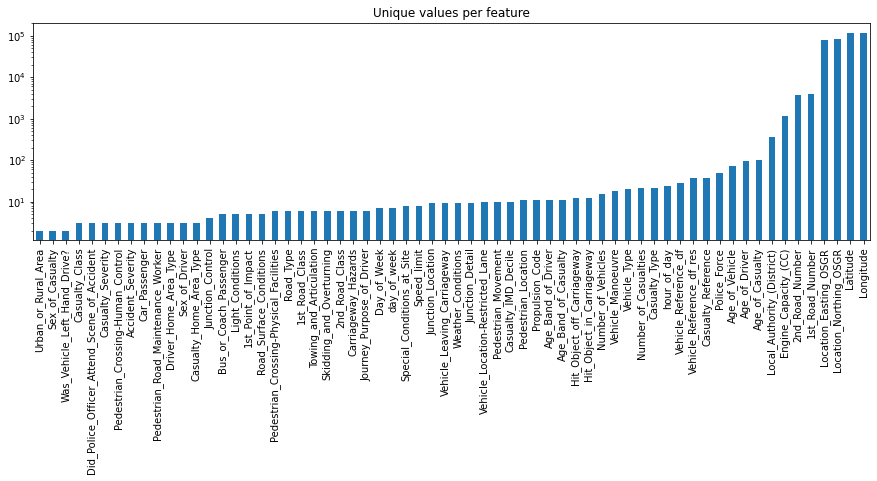

In [12]:
import numpy as np

unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature");

##### Observation and Decision 3
Most of the features contain less than 1000 unique values (i.e. 10^4). And overall, everything looks reasonably normal.

Structure of the dataset: We’ve learned how many samples and rows the dataset has, how many of them are non-numerical and which values they contain, and how many unique values each numerical feature has.

During this step, we also took care of some data type encoding issues.

### Advanced EDA - Part 2
This unit will cover the second investigation and look at the data quality.

#### Getting everything up to speed

 To get everything up to speed, let’s recreate the most important step here:



In [13]:
import pandas as pd
from sklearn.datasets import fetch_openml

# Download the data and extract the feature matrix X
dataset = fetch_openml(data_id=42803, as_frame=True)
df_X = dataset["frame"]

# Change datatype of features where needed
df_X["Sex_of_Driver"] = df_X["Sex_of_Driver"].astype("float")

# Combine features and create new ones where needed
df_X["Timestamp"] = pd.to_datetime(df_X["Date"] + " " + df_X["Time"])
df_X = df_X.drop(labels=["Date", "Time"], axis=1)
df_X["day_of_week"] = df_X["Timestamp"].dt.day_of_week
df_X["hour_of_day"] = df_X["Timestamp"].dt.hour

### Investigation 2 - dataset quality
Before focusing on the content stored in the feature, let’s first take a look at the quality of the dataset. The goal is to have a global view on the dataset with regards to things like duplicates, missing values and unwanted entries and recording errors.

#### Duplicates
Let’s check how many exact duplicates our dataset contains.


In [14]:
# Number of exact duplicates
df_X.duplicated().sum()

0

Perfect, there are none! However, keep in mind that this only detects duplicates if two samples overlap in 100% of the features. Depending on how the dataset is recorded, this might never be the case.

Many dataset have a unique index for every new entry. Which means, that if a specific event is entered twice, the index will nonetheless be different. In our ‘road safety’ dataset, this index is called Accident_Index.

**So let’s check what happens when we ignored this index when looking for duplicates:**

In [15]:
df_X.drop(labels=["Accident_Index"], axis=1).duplicated().sum()

22

Interesting! So we have 22 entries, that are duplicates, on all features except on Accident_Index. In other words, we have 22 accidents that happened at least twice, with exactly the same vehicles, at exactly the same location and time stamp. Rather unlikely!

Using the following code snippets we can take a look at all of those duplicates:

In [16]:
is_duplicate = df_X.drop(labels=["Accident_Index"], axis=1).duplicated(keep=False)
df_X[is_duplicate].head(5)

Accident_Index  Vehicle_Reference_df_res  Vehicle_Type  \
109183  2015132190930                       1.0           9.0   
109184  2015132190930                       2.0           9.0   
109201  2015132191539                       1.0           9.0   
109202  2015132191539                       2.0           9.0   
151844  201520S038475                       1.0           9.0   

        Towing_and_Articulation  Vehicle_Manoeuvre  \
109183                      0.0               18.0   
109184                      0.0               18.0   
109201                      0.0               18.0   
109202                      0.0               18.0   
151844                      0.0               18.0   

        Vehicle_Location-Restricted_Lane  Junction_Location  \
109183                               0.0                6.0   
109184                               0.0                1.0   
109201                               0.0                6.0   
109202                               0.0                1.0   
151844                               0.0                8.0   

        Skidding_and_Overturning  Hit_Object_in_Carriageway  \
109183                       0.0                        0.0   
109184                       0.0                        0.0   
109201                       0.0                        0.0   
109202                       0.0                        0.0   
151844                       0.0                        0.0   

        Vehicle_Leaving_Carriageway  ...  Pedestrian_Movement  Car_Passenger  \
109183                          0.0  ...                  0.0            2.0   
109184                          1.0  ...                  0.0            2.0   
109201                          0.0  ...                  0.0            2.0   
109202                          1.0  ...                  0.0            2.0   
151844                          0.0  ...                  0.0            0.0   

        Bus_or_Coach_Passenger  Pedestrian_Road_Maintenance_Worker  \
109183                     0.0                                 0.0   
109184                     0.0                                 0.0   
109201                     0.0                                 0.0   
109202                     0.0                                 0.0   
151844                     0.0                                 0.0   

        Casualty_Type  Casualty_Home_Area_Type  Casualty_IMD_Decile  \
109183            9.0                      NaN                  NaN   
109184            9.0                      NaN                  NaN   
109201            9.0                      NaN                  NaN   
109202            9.0                      NaN                  NaN   
151844            9.0                      1.0                  2.0   

                 Timestamp  day_of_week  hour_of_day  
109183 2015-09-01 15:39:00          1.0         15.0  
109184 2015-09-01 15:39:00          1.0         15.0  
109201 2015-09-01 15:39:00          1.0         15.0  
109202 2015-09-01 15:39:00          1.0         15.0  
151844 2015-05-30 16:12:00          5.0         16.0  

[5 rows x 68 columns]

#### Observation 1
There doesn’t seem to be anything special about these outliers.

#### Decision 1
Let’s remove these duplicates with the drop_duplicates() function and the subset parameter.

In [17]:
#  Extract column names of all features, except 'Accident_Index'
columns_to_consider = df_X.drop(labels=["Accident_Index"], axis=1).columns

# Drop duplicates based on 'columns_to_consider'
df_X = df_X.drop_duplicates(subset=columns_to_consider)
df_X.shape

(363221, 68)

**Duplicates: Not every dataset has to have such an index feature, nor does the index have to be the only feature to ignore. At the end it depends on the dataset and on the features you deem important that should identify a unique entry**

#### Missing values
Another quality issue of a dataset can be with regards to missing values. Having some missing values is a normal occurrence. What we want to identify at this stage are big holes in the dataset, i.e. samples or features with a lot of missing values.

#### Per sample
To look at missing values per sample, i.e. per row, we have multiple options. The most straight forward one is to simply visualize the output of df_X.isna(), with something like this:

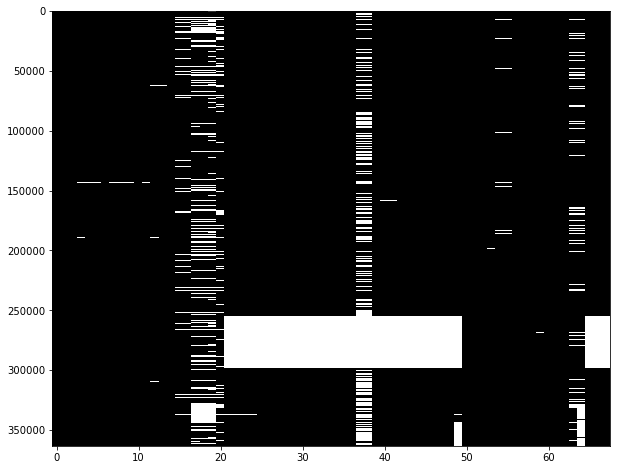

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(df_X.isna(), aspect="auto", interpolation="nearest", cmap="gray");

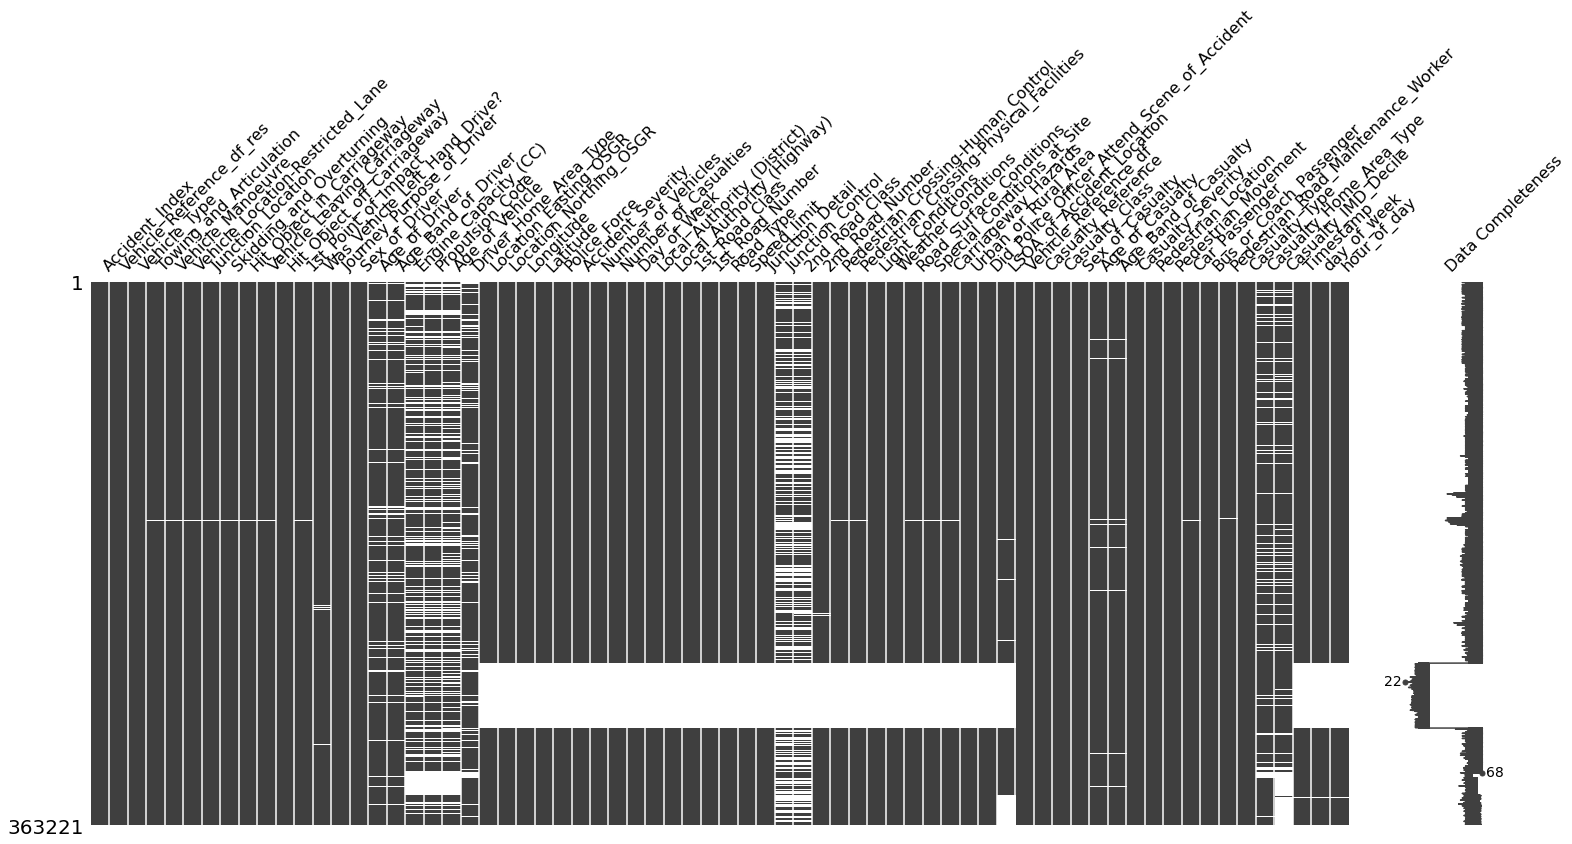

In [19]:
# And for a more advanced alternative to this you can use the missingno library, as follows:
import missingno as msno

msno.matrix(df_X, labels=True);

##### Observation 2
On the x-axis we can see the 68 unique features, and on the y-axis the +360’000 individual samples. What is popping out is a huge whole in the middle on features 21-49 and 66-68, on samples 250’000 to 300’000.

##### Decision 2
This whole seems to be too big to fill up, so let’s remove those entries. Seeing that we have roughly half of the features missing in those samples, let’s go a bit further and only keep entries that have at least 75% of values.

In [20]:
df_X = df_X.dropna(thresh=df_X.shape[1] * 0.75, axis=0)
df_X.shape

(319847, 68)

The missingno library contains many more functions that might be interesting to you. Like for example the heatmap that can tell you how correlated missing entries on one features are with missing values on other features.

#### Per Feature
As a next step, let’s now look at the number of missing values per feature. For this we can use some pandas trickery to quickly identify the ratio of missing values per feature.

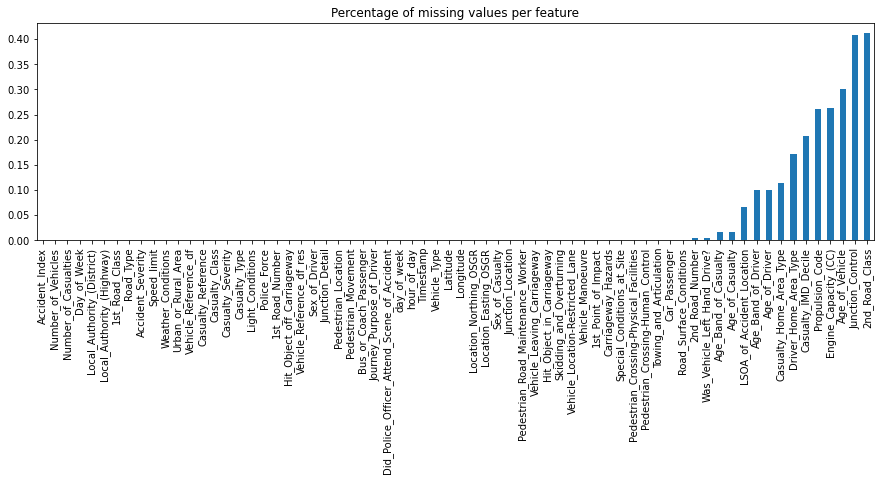

In [21]:
df_X.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values per feature");

#### Observation 3
From this figure we can see that most of the features don’t contain any missing values anymore. But there are still a few that contain more than 20% of missing values, such as 2nd_Road_Class, Junction_Control, Age_of_Vehicle.

#### Decision 3
Lets drop all features that have more than 15% of missing values. Note, there is no objective justification for setting this cutoff at 15%. The end goal is to keep as many features as possible, while removing as many missing values as possible.

In [22]:
df_X = df_X.dropna(thresh=df_X.shape[0] * 0.85, axis=1)
df_X.shape

(319847, 61)

We chose 15% as this removes a few of the very sparse features, but still keeps interesting features such as Age_of_Driver, and Age_of_Casualty, which both have ~10% of missing values.

Before moving on, let’s once more visualize the missing values in the dataset with the missingno routine, to make sure that everything worked as planned.

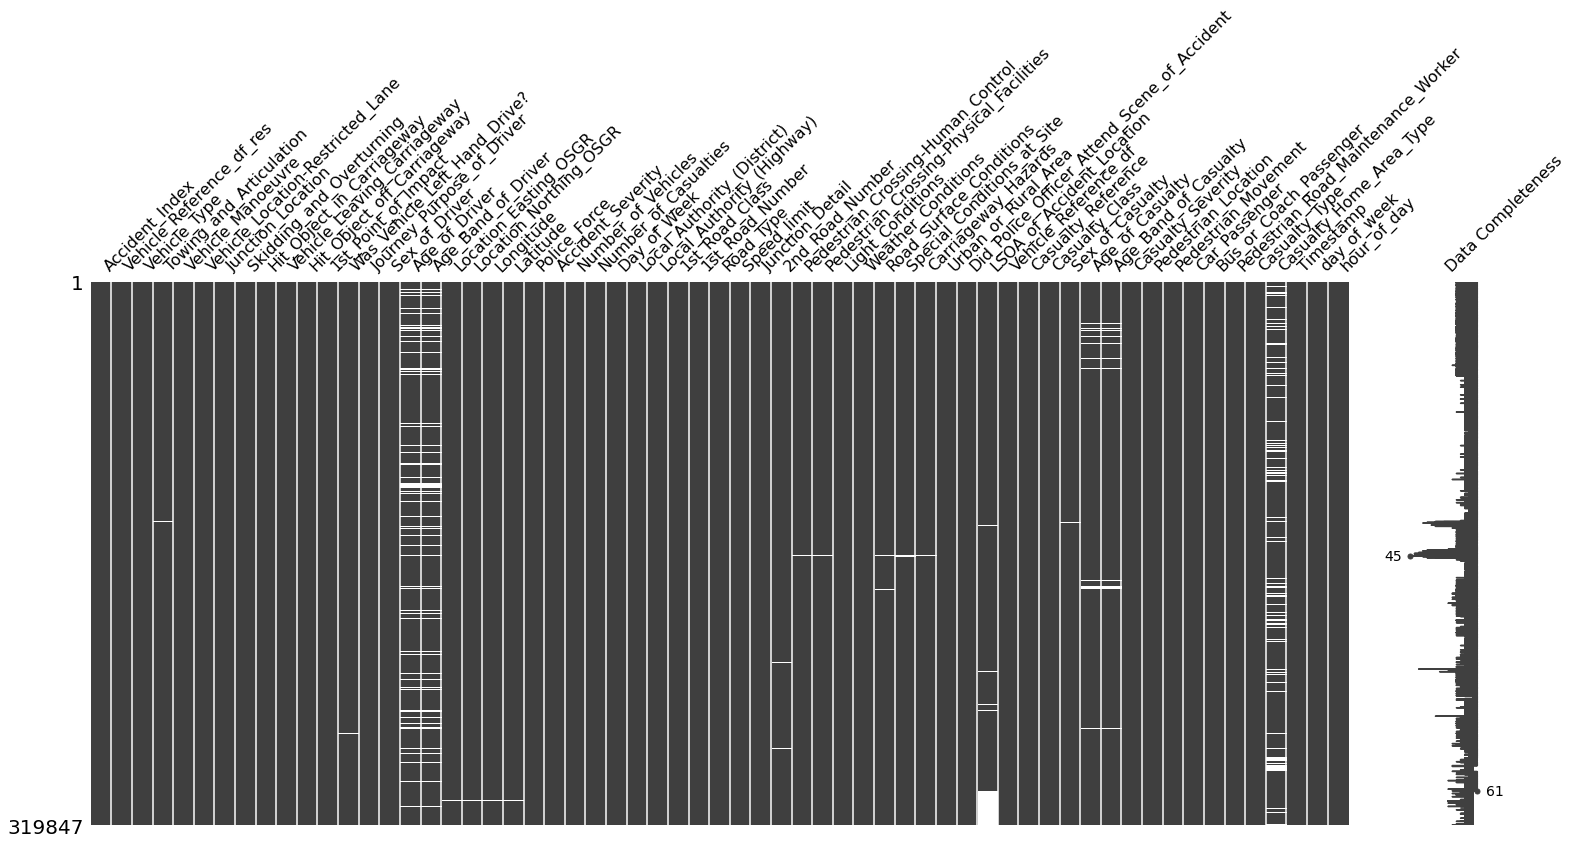

In [23]:
msno.matrix(df_X, labels=True);

Missing values: There is no strict order in removing missing values. For some datasets, tackling first the features and than the samples might be better. Furthermore, the threshold at which you decide to drop missing values per feature or sample changes from dataset to dataset, and depends on what you intend to do with the dataset later on.

Also, for now we only addressed the big holes in the dataset, not yet how we would fill the smaller gaps. This we will address further down below.

#### Unwanted entries and recording errors

Another source of quality issues in a dataset can be due to unwanted entries or recording errors. It’s important to distinguish such samples from outliers. While outliers are data points that are unusual for a given feature distribution, unwanted entries or recording errors are samples that shouldn’t be there in the first place.

For example, a temperature recording of 45°C in Switzerland might be an outlier (as in ‘very unusual’), while a recording at 90°C would be an error. Similarly, a temperature recording from the top of Mont Blanc might be physical possible, but most likely shouldn’t be included in a dataset about temperatures in Swiss cities.

Of course, detecting such errors and unwanted entries and distinguishing them from outliers is not always straight forward and depends highly on the dataset. One solution to this is to take a global view on the dataset and see if you can identify some very unusual patterns.

#### Numerical features
To plot this global view of the dataset, at least for the numerical features, you can use pandas’ plot() function and combine it with the following parameters:
* lw=linewidth
* marker="." stands for the marker of the data points
* layout=(-1,2) How many rows and columns use for the subplots (-1, means as much as needed)
* figsize=(15,40), markersize=1: Is form making the figure big enough



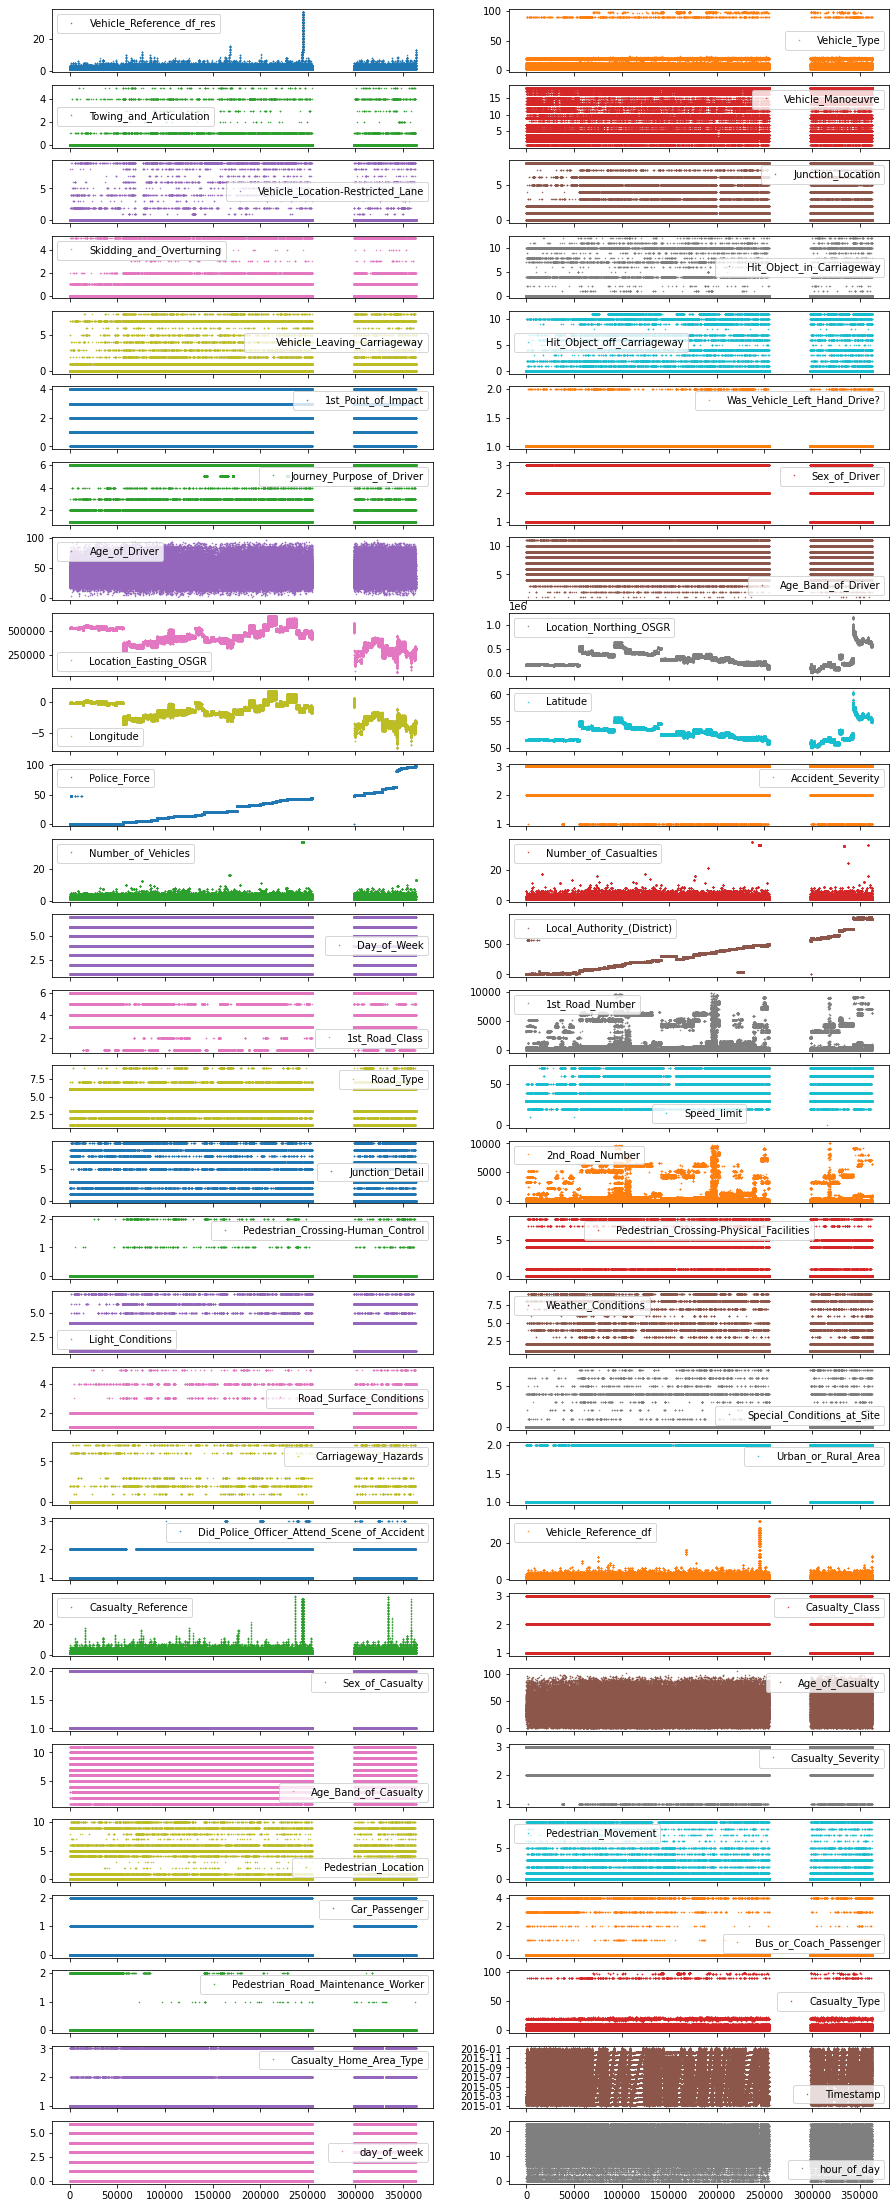

In [24]:
df_X.plot(lw=0, marker=".", subplots=True, layout=(-1, 2), figsize=(15, 40), markersize=1);

Each point in this figure is a sample (i.e. a row) in our dataset and each subplot represents a different feature. The y-axis tells the value of the sample per feature, while the x-axis is the value from the dataset index.

While this plot works well for huge number of samples, the plotting routine starts to struggle once you go beyond ~100 subplots. To tackle this, you could restrict the dataframe to plot for example to the first 50 features only, using df_X.iloc[:, :50].

##### Observation 4
The most striking thing in this overview plot is the huge gap on the right side of each figure. This is quite simply due to our dropping of samples due to missing values.

##### Decision 4
The gap on this visualization can be corrected by re-indexing our dataframe.



In [25]:
df_X = df_X.reset_index(drop=True)

Alternatively, we could have also chosen another feature as the index column, in this case for example Timestamp.

##### Observation 5
Looking for unusual patterns in the data, we can see that around sample 250’000, just before the gap, there seems to be a ‘spike’ or ‘tower’ in some of the plots. To better understand what’s happening, let’s take a closer look at two such features.


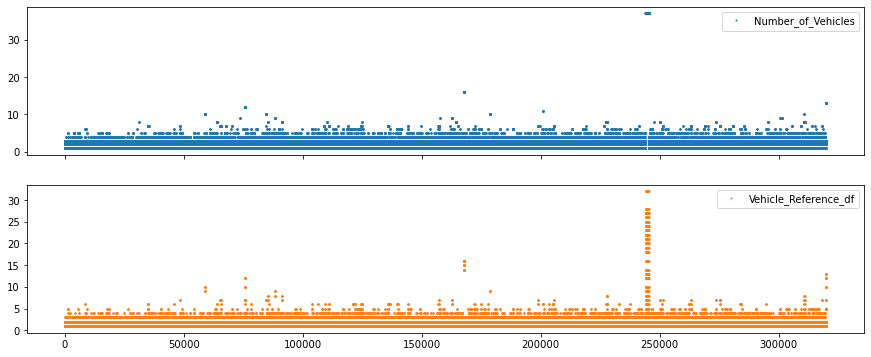

In [26]:
df_X[["Number_of_Vehicles", "Vehicle_Reference_df"]].plot(
    lw=0, marker=".", subplots=True, figsize=(15, 6), markersize=2);

It seems that this unusual pattern in the dataset is due to a single road accident that included more than 35 vehicles. While this is unfortunately not a measurement errors (given that each vehicle seems to have a reference number), it is probably an unusual event that we want to exclude from the dataset.

Note, the decision to classify this as an ‘unusual’ event is subjective and driven by the intention to create a ‘normal’ road safety dataset. Plus, it allows us here to showcase some great EDA routines.

#### Decision 5
Instead of using a fully automated approach, removing recording errors and unusual events is very often a manual procedure. In this case, we will identify entries where the Number_of_Vehicles value is bigger than 30 and remove them from the dataset. For this you can either use pandas’s ‘great than’ function .gt(30) or simply >30.

In [27]:
# Let's create a mask which has 'True' for every sample that needs to be dropped
entries_to_drop = df_X["Number_of_Vehicles"].gt(30)
print(entries_to_drop.sum())

# Dropping these entries by only selecting the samples that shouldn't be dropped
df_X = df_X[~entries_to_drop]

1332


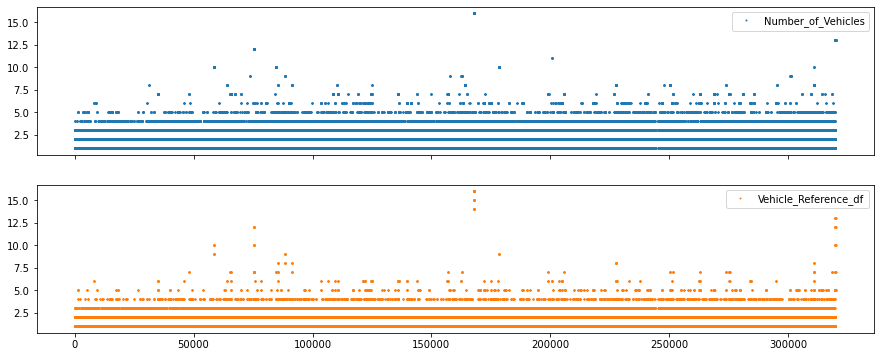

In [28]:
# To verify that everything went according to plan, let’s plot the two features once more.

df_X[["Number_of_Vehicles", "Vehicle_Reference_df"]].plot(
    lw=0, marker=".", subplots=True, figsize=(15, 6), markersize=2);

### Non-numerical features
If you take a closer look at the big multi plot figure above, you might have realized that it only shows 58 of the total 61 features. This is due to the fact that only 58 of them are encoded as numerical features.

So what about the remaining non-numerical features?

In [30]:
# Identify non-numerical features
df_non_numerical = df_X.select_dtypes(exclude=["number", "datetime"])
df_non_numerical.head()

Accident_Index Local_Authority_(Highway) LSOA_of_Accident_Location
0  201501BS70001                 E09000020                 E01002825
1  201501BS70002                 E09000020                 E01002820
2  201501BS70004                 E09000020                 E01002833
3  201501BS70005                 E09000020                 E01002874
4  201501BS70008                 E09000020                 E01002814

Identifying unwanted entries or recording errors on these features is a bit more tricky, due to the fact that these entry values are non-numerical in the first place. Given that at this point, we only want to investigate the general quality of the dataset, what we can do is have a general look at how many unique values each of these non-numerical features contain.

In [31]:
# Extract number of unique values per non-numerical feature
df_non_numerical.nunique()

Accident_Index               123667
Local_Authority_(Highway)       204
LSOA_of_Accident_Location     25979
dtype: int64

There are multiple ways for how you could potentially streamline the quality investigation of each individual non-numerical features. None of them is perfect, and all of them will require some follow up investigation.

But for the purpose of showcasing one such a solution, what we could do is loop through all non-numerical features and plot for each of them the number of occurrences per unique value.

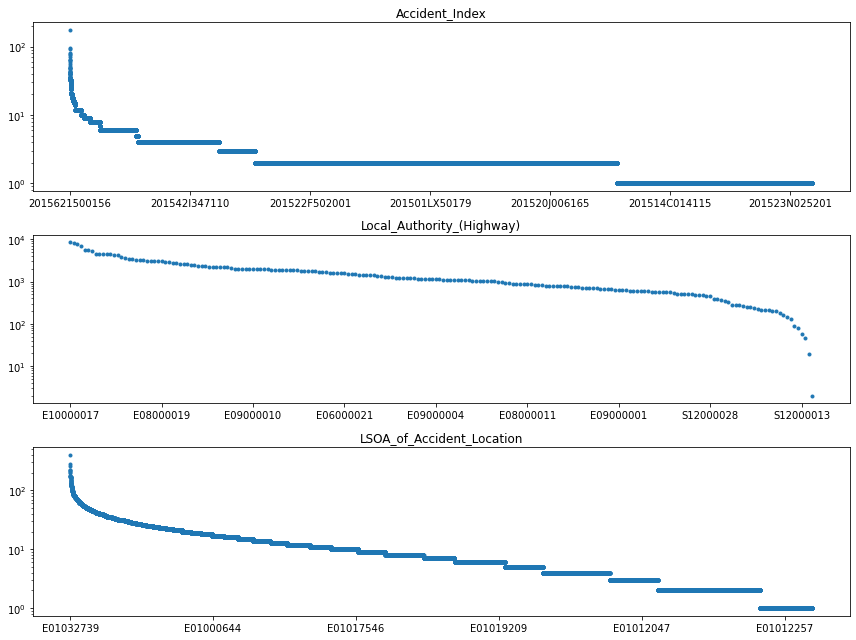

In [32]:
# Create figure object with 3 subplots
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(12, 9))

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_non_numerical.columns, axes.ravel()):

    # Selects one single feature and counts number of occurrences per unique value
    df_non_numerical[col].value_counts().plot(

        # Plots this information in a figure with log-scaled y-axis
        logy=True, title=col, lw=0, marker=".", ax=ax)
    
plt.tight_layout()

##### Observation 6
We can see that the most frequent accident (i.e. Accident_Index), had more than 100 people involved. Digging a bit deeper (i.e. looking at the individual features of this accident), we could identify that this accident happened on January 24th, 2015 at 11:55 in Cardiff UK. A quick internet search reveals that this entry corresponds to a luckily non-lethal accident including a minibus full of pensioners.

##### Decision 6
The decision for what should be done with such rather unique entries is once more left in the the subjective hands of the person analyzing the dataset.

Without any good justification for WHY, and only with the intention to show you the HOW - let’s go ahead and remove the 10 most frequent accidents from this dataset.



In [33]:
# Collect entry values of the 10 most frequent accidents
accident_ids = df_non_numerical["Accident_Index"].value_counts().head(10).index
accident_ids

Index(['2015621500156', '201597AC70404', '2015984141415', '201522D501706',
       '201501RY10259', '201542I309809', '2015160C06511', '2015300013662',
       '20154100T3095', '2015521501170'],
      dtype='object')

Now that we have this information, let’s go ahead and remove those rows that contain one of these Accident_Index.

In [34]:
# Removes accidents from the 'accident_ids' list
df_X = df_X[~df_X["Accident_Index"].isin(accident_ids)]
df_X.shape

(317659, 61)

Note: A similar approach could also be pursued for the feature Local_Authority_(Highway) and LSOA_of_Accident_Location.

Unwanted entries and recording errors: The goal of this part of the EDA is the identification of highly unusual and in this case, unwanted data values or value occurrences. Having a quick visual glance on the numerical and non-numerical features is often already enough to get a lot of very valuable insights and to further guide the data cleaning process.

###  Advanced EDA - Part 3

This unit will cover the third investigation and look at the data content.

#### Getting everything up to speed
We assume that you went already through the previous two unit, downloaded the data and addressed the structural and quality issues with it. To get everything up to speed, let’s recreate the most important step here:

In [36]:
import pandas as pd
from sklearn.datasets import fetch_openml

# Download the data and extract the feature matrix X
dataset = fetch_openml(data_id=42803, as_frame=True)
df_X = dataset["frame"]
print('Dataset shape before cleaning:', df_X.shape)

# Change datatype of features where needed
df_X["Sex_of_Driver"] = df_X["Sex_of_Driver"].astype("float")

# Combine features and create new ones where needed
df_X["Timestamp"] = pd.to_datetime(df_X["Date"] + " " + df_X["Time"])
df_X = df_X.drop(labels=["Date", "Time"], axis=1)
df_X["day_of_week"] = df_X["Timestamp"].dt.day_of_week
df_X["hour_of_day"] = df_X["Timestamp"].dt.hour

# Drop duplicates based on 'columns_to_consider'
columns_to_consider = df_X.drop(labels=["Accident_Index"], axis=1).columns
df_X = df_X.drop_duplicates(subset=columns_to_consider)

# Drop missing values based on feature and sample axis
df_X = df_X.dropna(thresh=df_X.shape[1] * 0.75, axis=0)
df_X = df_X.dropna(thresh=df_X.shape[0] * 0.85, axis=1)

# Rest the index numbering
df_X = df_X.reset_index(drop=True)

# Dropping some entries according to some feature criteria
entries_to_drop = df_X["Number_of_Vehicles"].gt(30)
df_X = df_X[~entries_to_drop]

# Remove entries of the 10 most frequent accidents
df_non_numerical = df_X.select_dtypes(exclude=["number", "datetime"])
accident_ids = df_non_numerical["Accident_Index"].value_counts().head(10).index
df_X = df_X[~df_X["Accident_Index"].isin(accident_ids)]
print('Dataset shape after cleaning:', df_X.shape)

Dataset shape before cleaning: (363243, 67)
Dataset shape after cleaning: (317659, 61)


#### Investigation 3 - dataset content

Let’s now go a step further and take a look at what content is stored in each feature. In an ideal setting, such an investigation would be done feature by feature. However, this becomes very cumbersome, once we have more than 10-20 features.

For this reason (and to keep this unit as short as needed) we will explore three different approaches that can give you a very quick overview of the content stored in each feature.

1. Feature distribution
In the previous section about non-numerical features we saw that the investigation of unique value occurrences can be very informative. The equivalent to this for numerical features is the plotting of the feature distributions. The quickest way to achieve this is by using histogram plots.

Luckily, pandas comes with a builtin histogram function that allows the plotting of multiple features at once. Similarly to the approach before, the trick lies in the layout and the figsize parameter.

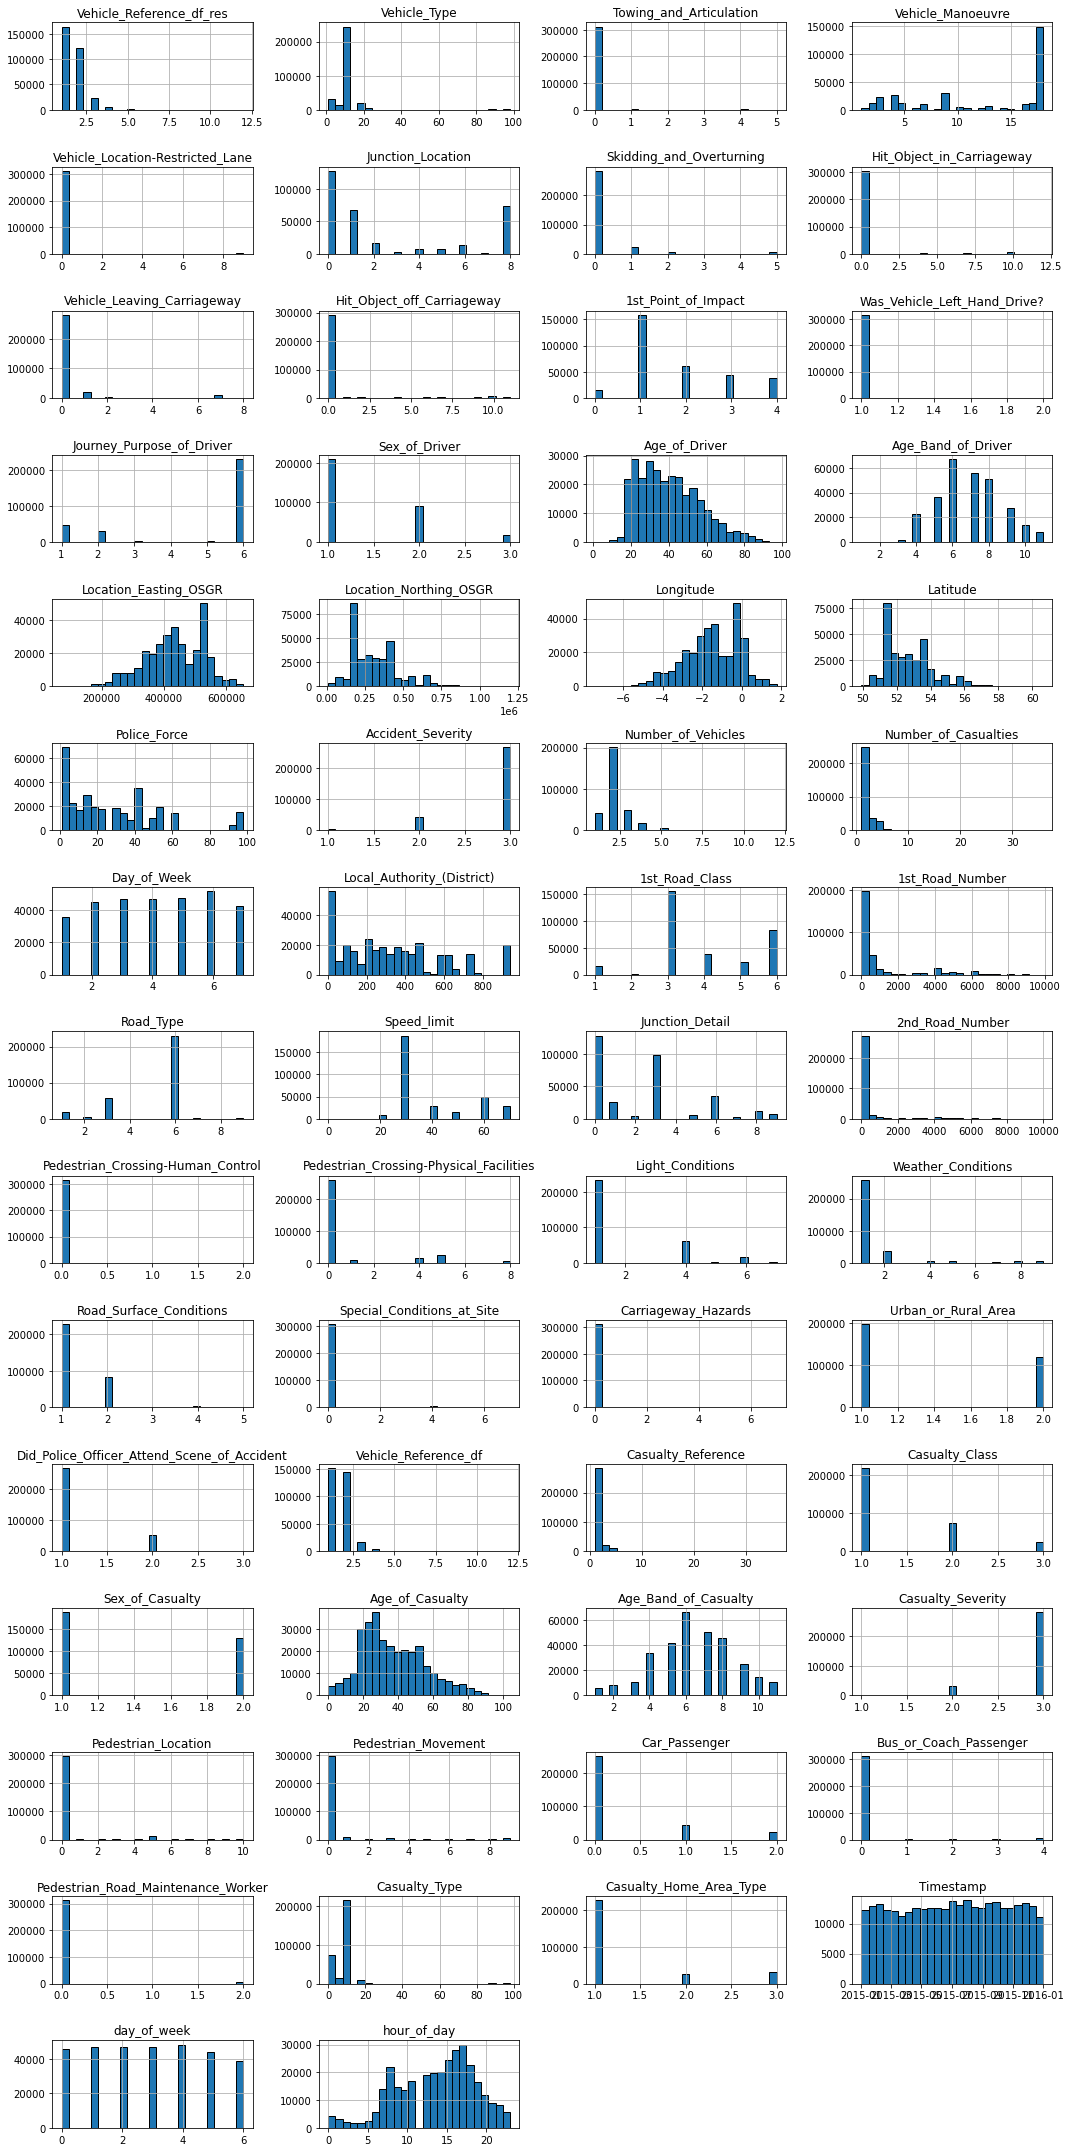

In [37]:
import matplotlib.pyplot as plt

# Plots the histogram for each numerical feature in a separate subplot
df_X.hist(bins=25, figsize=(15, 30), layout=(-1, 4), edgecolor="black")
plt.tight_layout()

There are a lot of very interesting things visible in this plot. Let’s focus on a few.

##### Observation 1
Many features, such as Towing_and_Articulation or Was_Vehicle_Left_Hand_Drive? contain mostly entries of just one category.

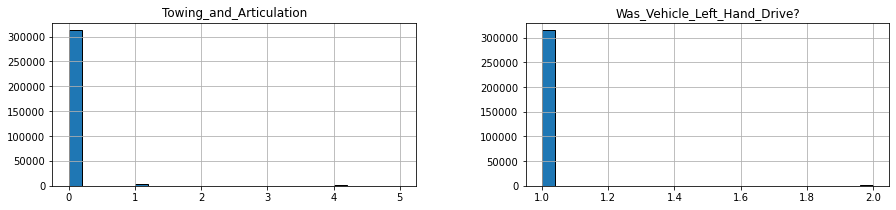

In [38]:
# Show histogram of two particular features
df_X[["Towing_and_Articulation", "Was_Vehicle_Left_Hand_Drive?"]].hist(
    bins=25, figsize=(15, 3), layout=(-1, 2), edgecolor="black");

Using the .mode() function, we can extract for each feature the most frequent entry.

In [39]:
df_X[["Towing_and_Articulation", "Was_Vehicle_Left_Hand_Drive?"]].mode()

Towing_and_Articulation  Was_Vehicle_Left_Hand_Drive?
0                      0.0                           1.0

Going a step further, we can use this approach to compute for each feature the ratio with which the most frequent entry occurs.

In [40]:
# Collects for each feature the most frequent entry
most_frequent_entry = df_X.mode()

# Checks for each entry if it contains the most frequent entry
df_freq = df_X.eq(most_frequent_entry.values, axis=1)

# Computes the mean of the 'is_most_frequent' occurrence
df_freq = df_freq.mean().sort_values(ascending=False)

# Show the 5 top features with the highest ratio of singular value content
df_freq.head()

Pedestrian_Crossing-Human_Control    0.995155
Was_Vehicle_Left_Hand_Drive?         0.990336
Carriageway_Hazards                  0.983548
Towing_and_Articulation              0.983073
Vehicle_Location-Restricted_Lane     0.981943
dtype: float64

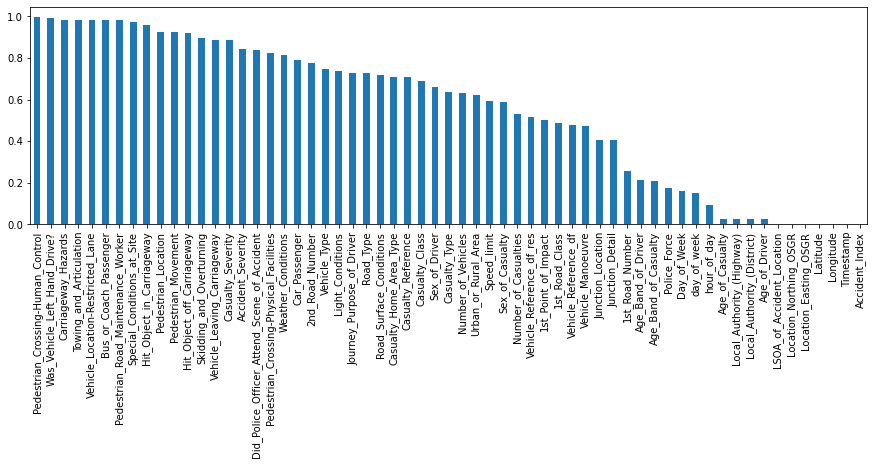

In [41]:
#Let’s take a closer look at this by plotting the ratio for each feature in the dataset.

df_freq.plot.bar(figsize=(15, 4));

##### Decision 1
This is once more a very subjective decision, but let’s say we decided to remove any feature where the most frequent element occurs more than 99% of the time. The intention behind this decision is as follows: Features where less than 1% of all values are not the same as the majority, might not really add much more additional information to the general dataset and can be removed.

This can be seen in the case of Was_Vehicle_Left_Hand_Drive?. In less than 1% of all accidents was the driver of the vehicle on the left side. While the side of driver is certainly an important feature to consider when investigating road safety in UK - in this particular case it doesn’t seem to be very prominent.

However, before we can remove this feature, we also need to make sure to first remove the non-majority entries. This can be done with the following command.



In [42]:
# Shape of feature matrix before cleaning
print("Shape before cleaning:", df_X.shape)

# Loop through the indices where 'most_frequent_ratio' is great than 99%
for col in df_freq[df_freq > 0.99].index:

    # Only keep entries that correspond to the majority value
    df_X = df_X[df_X[col].isin(most_frequent_entry[col])]

    #  Remove feature
    df_X = df_X.drop(columns=col)

# Shape of feature matrix after cleaning
print("Shape after cleaning:", df_X.shape)

Shape before cleaning: (317659, 61)
Shape after cleaning: (313061, 59)


##### Observation 2
Going back to the multi-histogram-plot from before, let’s take a closer look at two more interesting features: Age_of_Driver and hour_of_day.

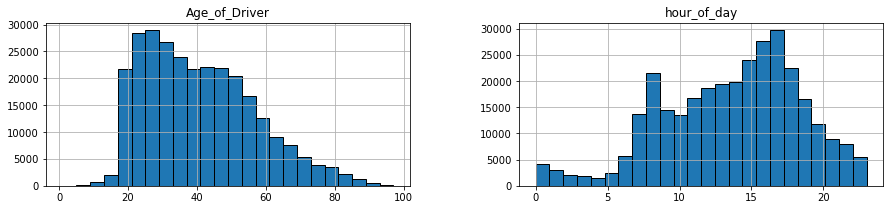

In [43]:
# Show histogram of two particular features
df_X[["Age_of_Driver", "hour_of_day"]].hist(
    bins=24, figsize=(15, 3), layout=(-1, 2), edgecolor="black");

In both cases we can observe unique value distributions. In the case of Age_of_Driver, there seems to be a strong drop of drivers younger than 16 years of age (i.e. the lowest age a person can legally drive in the UK). And in the case of hour_of_day, we can clearly see that different times of the day show different accident rates.

##### Decision 2
With respect to Age_of_Driver, let’s subjectively assume that drivers younger than 16 years of age are unusual cases and should be removed from the dataset.



In [45]:
# Remove driver younger than 16 years of age
df_X = df_X[~df_X["Age_of_Driver"].lt(16)]
df_X.shape

(311175, 59)

With respect to hour_of_day, let’s go ahead and create five new features corresponding to the time periods:

* night: from 0 to 6
* morning: from 6 to 11
* lunch: from 11 to 14
* afternoon: from 14 to 19
* evening: from 19 to 24

In [46]:
# Establish new feature name and value boundaries
new_features = {
    "night": [0, 6],
    "morning": [6, 11],
    "lunch": [11, 14],
    "afternoon": [14, 19],
    "evening": [19, 24],
}

# Loop through new features and add them to the feature matrix
for key, value in new_features.items():
    df_X[key] = np.logical_and(
        df_X["hour_of_day"] >= value[0], df_X["hour_of_day"] < value[1]
    ).astype("int")

df_X.shape

(311175, 64)

#### Missing values

After looking at the big wholes in our dataset during the ‘quality assessment’ part, let’s now take a closer at the smaller gaps in our dataset and see how we can tackle the remaining missing values. The options are to either remove entries where the missing value is important, or to fill it up with something reasonable representative.

But first, we need to assess how many missing values we still have. So let’s take a closer look at the most extreme features.

In [47]:
# Show the top few missing values
df_X.isna().sum().sort_values(ascending=False).head(5)


Casualty_Home_Area_Type      35334
Age_of_Driver                31428
Age_Band_of_Driver           31428
LSOA_of_Accident_Location    20419
Age_of_Casualty               4962
dtype: int64

As we can see, there are quite a few missing values. Let’s take another look again at the value distribution of the first four columns in this list.

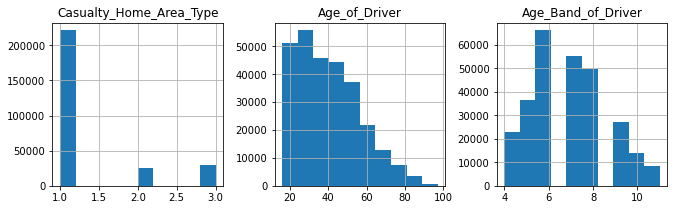

In [48]:
df_X[["Casualty_Home_Area_Type", "Age_of_Driver",
      "Age_Band_of_Driver", "LSOA_of_Accident_Location"]].hist(
    layout=(-1, 4), figsize=(15, 3));

#### Observation 3
Even though we asked to plot 4 features, it only shows three. Let’s check the content of the fourth entry:

In [50]:
df_X["LSOA_of_Accident_Location"]

0         E01002825
1         E01002820
2         E01002833
3         E01002874
4         E01002814
            ...    
319751         None
319752         None
319753         None
319754         None
319755         None
Name: LSOA_of_Accident_Location, Length: 311175, dtype: object

As we can see, the data type of this feature is object, due to the fact that the entries are strings.

##### Decision 3
One option to fill up missing values is to use the most frequent entry on the feature. However, in this particular case, using the most frequent location of the accident might not be the best solution.

Another approach, for non-numerical features in particular, is to label the missing values with a string that indicates that those are missing values, e.g. 'NaN', 'Missing', 'None'.

For a proper EDA, we would need to investigate each feature individually. However, for this project, let’s go ahead and fill up the missing values on non-numerical features with the label 'None'.

In [51]:
# Select non-numerical columns
non_numb_col = df_X.select_dtypes(include="object").columns

# Fill up missing values in non-numerical columns
df_X[non_numb_col] = df_X[non_numb_col].fillna("None")

# Check for remaining missing values
df_X[non_numb_col].isna().sum()

Accident_Index               0
Local_Authority_(Highway)    0
LSOA_of_Accident_Location    0
dtype: int64

#### Observation 4
Filling up missing values for the numerical values is also not as straightforward as we would hope. Some of them show continuous distributions (that might be skewed), while other have only discrete values. The most frequent ways to fill up missing values of numerical features use either the mode() (i.e. most frequent entry), the mean() or the median() (in particular for skewed continuous distributions).

However, we could also chose some more advanced filling up routines, where we would look what values other samples have on a particular feature that are overall very similar to the one where we want to fill up the missing value. For this unit however we will keep it simpler.

But nonetheless, as for many of these EDA steps, filling up missing values for numerical features should ideally also again be a feature-by-feature approach.

#### Decision 4
Having said so, let’s keep it simple for this unit and decide that we fill up missing values with the most frequent entry if the feature has less than 25 unique features and otherwise fill it up with the median value.



In [53]:
# Extract columns to fill up
cols = df_X.columns[df_X.isna().sum() != 0]

# Loop through each column and fill up with missing values
cols_median = df_X[cols].nunique() >= 25

# Fill discrete entries with most frequent entry
df_X[cols[~cols_median]] = df_X[cols[~cols_median]].fillna(
    df_X[cols[~cols_median]].mode().T[0])

# Fill continuous features with median value
df_X[cols[cols_median]] = df_X[cols[cols_median]].fillna(
    df_X[cols[cols_median]].median(numeric_only=True))

In [54]:
#Let’s check if we got all missing values.

# Show the top few missing values
df_X.isna().sum().sort_values(ascending=False).head(5)

Timestamp               43
Accident_Index           0
Age_Band_of_Casualty     0
Light_Conditions         0
Weather_Conditions       0
dtype: int64

##### Observation 5
The only thing remaining are missing value on the Timestamp feature.

##### Decision 5
Assuming that the raw dataset was chronologically ordered, we can just go ahead and fill up these missing values with a forward and backward fill.

In [56]:
df_X["Timestamp"] = df_X["Timestamp"].fillna(method="ffill").fillna(method="bfill")

**Missing values: Just to iterate on this once more. The most optimal way of handling missing values is to look at each feature separately and decide case-by-case with what kind of values you want to fill the missing values, or to decide that you should drop such entries, worrying that you otherwise introduce too much of a bias.**

#### Feature patterns
Next step on the list is the investigation of each feature individually. The goal of this part is two fold:

* Can we identify particular patterns within a feature that will help us to decide if some entries need to be dropped or modified?
* Can we identify particular relationships between features that will help us to better understand our features?
But before we dive into these two questions, let’s take a closer look at a few ‘randomly selected’ features.

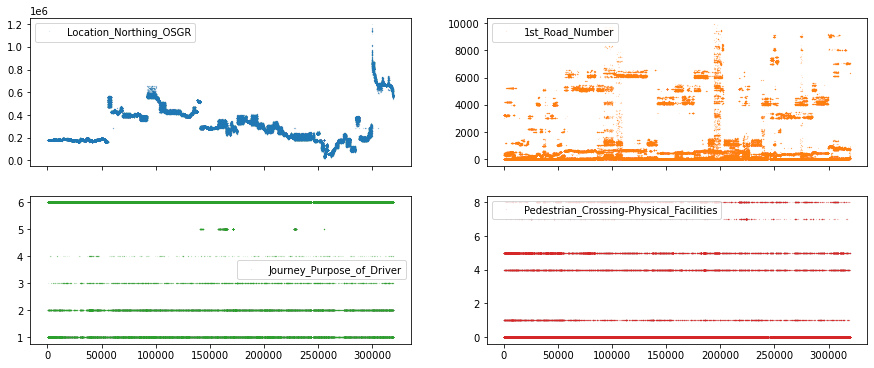

In [58]:
df_X[["Location_Northing_OSGR", "1st_Road_Number",
      "Journey_Purpose_of_Driver", "Pedestrian_Crossing-Physical_Facilities"]].plot(
    lw=0, marker=".", subplots=True, layout=(-1, 2), markersize=0.1, figsize=(15, 6));

While there are many ways we could explore our features for particular patte|m|mrns, let’s simplify our option by deciding that we treat features with less than 25 unique features as discrete or ordinal features, and the other features as continuous features.

In [61]:
# Creates mask to identify numerical features with more or less than 25 unique features
cols_continuous = df_X.select_dtypes(include="number").nunique() >= 25

**Important to keep in mind: The approach we chose in this unit is once more just a short-cut to keep this unit reasonably small. Choosing such a cut off at all might not be useful for many other projects.**

#### Continuous features
Now that we have a way to select the continuous features, let’s go ahead and use seaborn’s pairplot to visualize the relationships between these features. Important to note, seaborn’s pairplot routine can take a long time to create all subplots. Therefore we recommend to not use it for more than ~10 features at a time.


In [63]:
# Create a new dataframe which only contains the continuous features
df_continuous = df_X[cols_continuous[cols_continuous].index]
df_continuous.shape

(311175, 11)

Given that in our case we only have 11 features, we can go ahead with the pairplot. Otherwise, using something like df_continuous.iloc[:, :5] could help to reduce the number of features to plot.

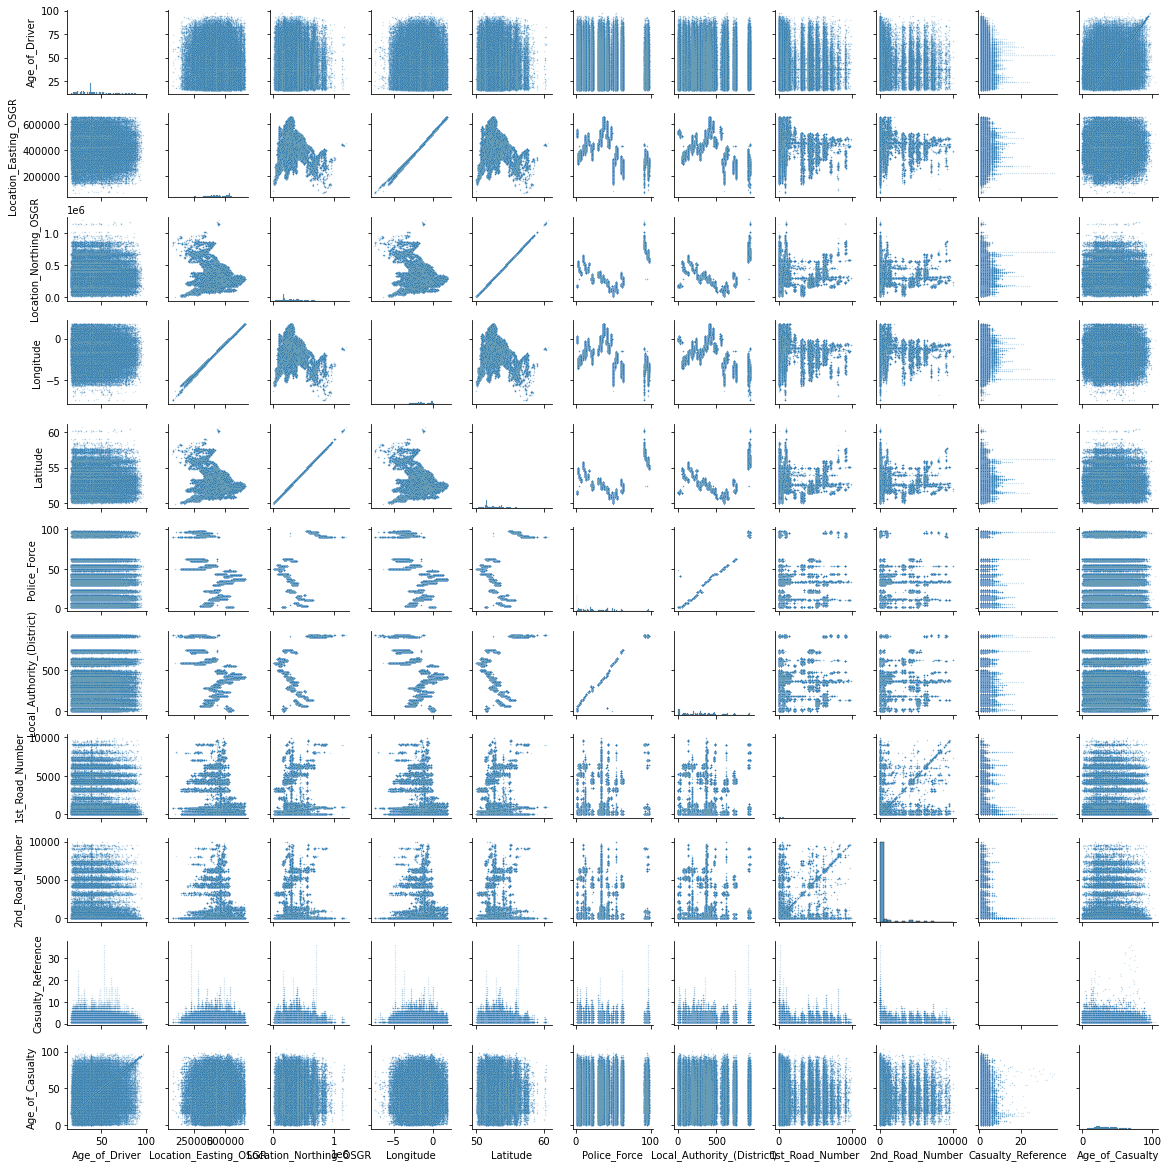

In [64]:
import seaborn as sns

sns.pairplot(df_continuous, height=1.5, plot_kws={"s": 2, "alpha": 0.2});

##### Observation 6
There seems to be a strange relationship between a few features in the top left corner. Location_Easting_OSGR and Longitude, as well as Location_Easting_OSGR and Latitude seem to have a very strong linear relationship. And together each of these two pairs display the map of the United Kingdom.

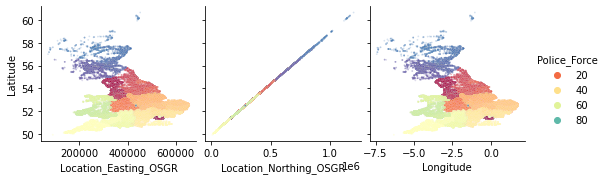

In [65]:
sns.pairplot(
    df_X,
    plot_kws={"s": 3, "alpha": 0.2},
    hue="Police_Force",
    palette="Spectral",
    x_vars=["Location_Easting_OSGR", "Location_Northing_OSGR", "Longitude"],
    y_vars="Latitude",
);


##### Decision 6
Knowing that these features contain geographic information, a more in-depth EDA with regards to geolocation could be fruitful. However, for now we will leave this on the side and remove these four features for the further investigation of the continuous features.

##### Observation 7
While there are many more interesting patterns visible in the pairplot above, let’s focus on the two features Age_of_Driver and Age_of_Casulaty. And to showcase an additional seaborn routine, let’s use PairGrid() for some more advanced plotting. Note, for a great alternative to PairGrid, see also seaborn’s FacetGrid.

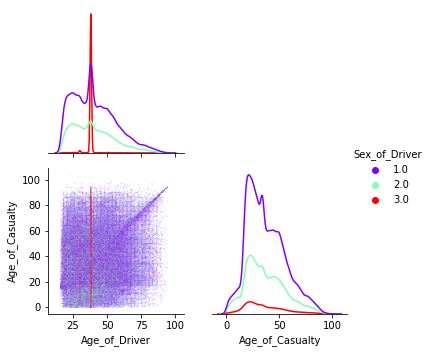

In [67]:
# Select the two columns of interest
col_vars = ["Age_of_Driver", "Age_of_Casualty"]

# Specify which feature should be chosen to color the plot
col_color = "Sex_of_Driver"

#  Use PairGrid to plot features
g = sns.PairGrid(
    df_X,
    diag_sharey=False,
    corner=True,
    hue=col_color,
    x_vars=col_vars,
    y_vars=col_vars,
    palette="rainbow",
)
g.map_lower(sns.scatterplot, s=1, alpha=0.2)
g.map_diag(sns.kdeplot)
g.add_legend();

Interesting, it seems that all drivers with a Sex of 3.0 have almost exactly the same age. This might either be due to the original dataset or something we did to it (e.g. filling up of missing values). So let’s plot the figure once more, but instead of df_X, let’s use the raw dataframe dataset["frame"]:

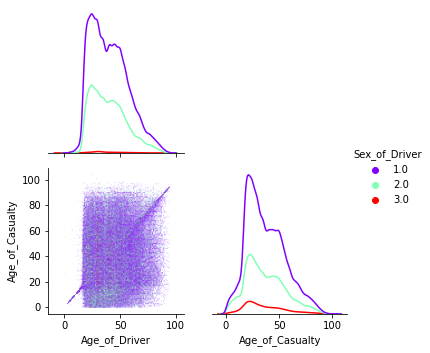

In [68]:
#  Use PairGrid to plot features
g = sns.PairGrid(
    dataset["frame"],
    diag_sharey=False,
    corner=True,
    hue=col_color,
    x_vars=col_vars,
    y_vars=col_vars,
    palette="rainbow",
)
g.map_lower(sns.scatterplot, s=1, alpha=0.2)
g.map_diag(sns.kdeplot)
g.add_legend();

#### Decision 7
It seems that we introduce the source of this strange pattern ourselves. Ideally we would now iterate on what we did, look for the exact source of this bias and correct it in the code above. For this use case we will leave things as they are, otherwise we cannot show you this particularity.

The investigation of the continuous features could of course continue for a long time. But in the interest of time, let’s stop here.

#### Discrete and ordinal features
Finding patterns in the discrete or ordinal features is a bit more tricky. But also here, some quick pandas and seaborn trickery can help us to get a general overview of our dataset. First, let’s select the columns we want to investigate.


In [70]:
# Create a new dataframe which doesn't contain the numerical continuous features
df_discrete = df_X[cols_continuous[~cols_continuous].index]
df_discrete.shape

(311175, 49)

As always, there are multiple way for how we could investigate all of these features. Let’s try one example, using seaborn’s stripplot() together with a handy zip() for-loop for subplots.

In [71]:
# Establish number of columns and rows needed to plot all features
n_cols = 5
n_elements = len(df_discrete.columns)
n_rows = np.ceil(n_elements / n_cols).astype("int")
print(n_cols, n_rows)

5 10


Note, to spread the values out in the direction of the y-axis we need to use a specific feature. While the ‘right’ feature can help to identify some interesting patterns, usually any continuous feature should do the trick. The main interest in these kind of plots is to see how many samples each discrete value contains.

In [72]:
# Specify y_value (ideally a continuous feature)
y_value = df_X["Age_of_Driver"]

Now that we have everything ready, let’s go ahead and create the overview plot.

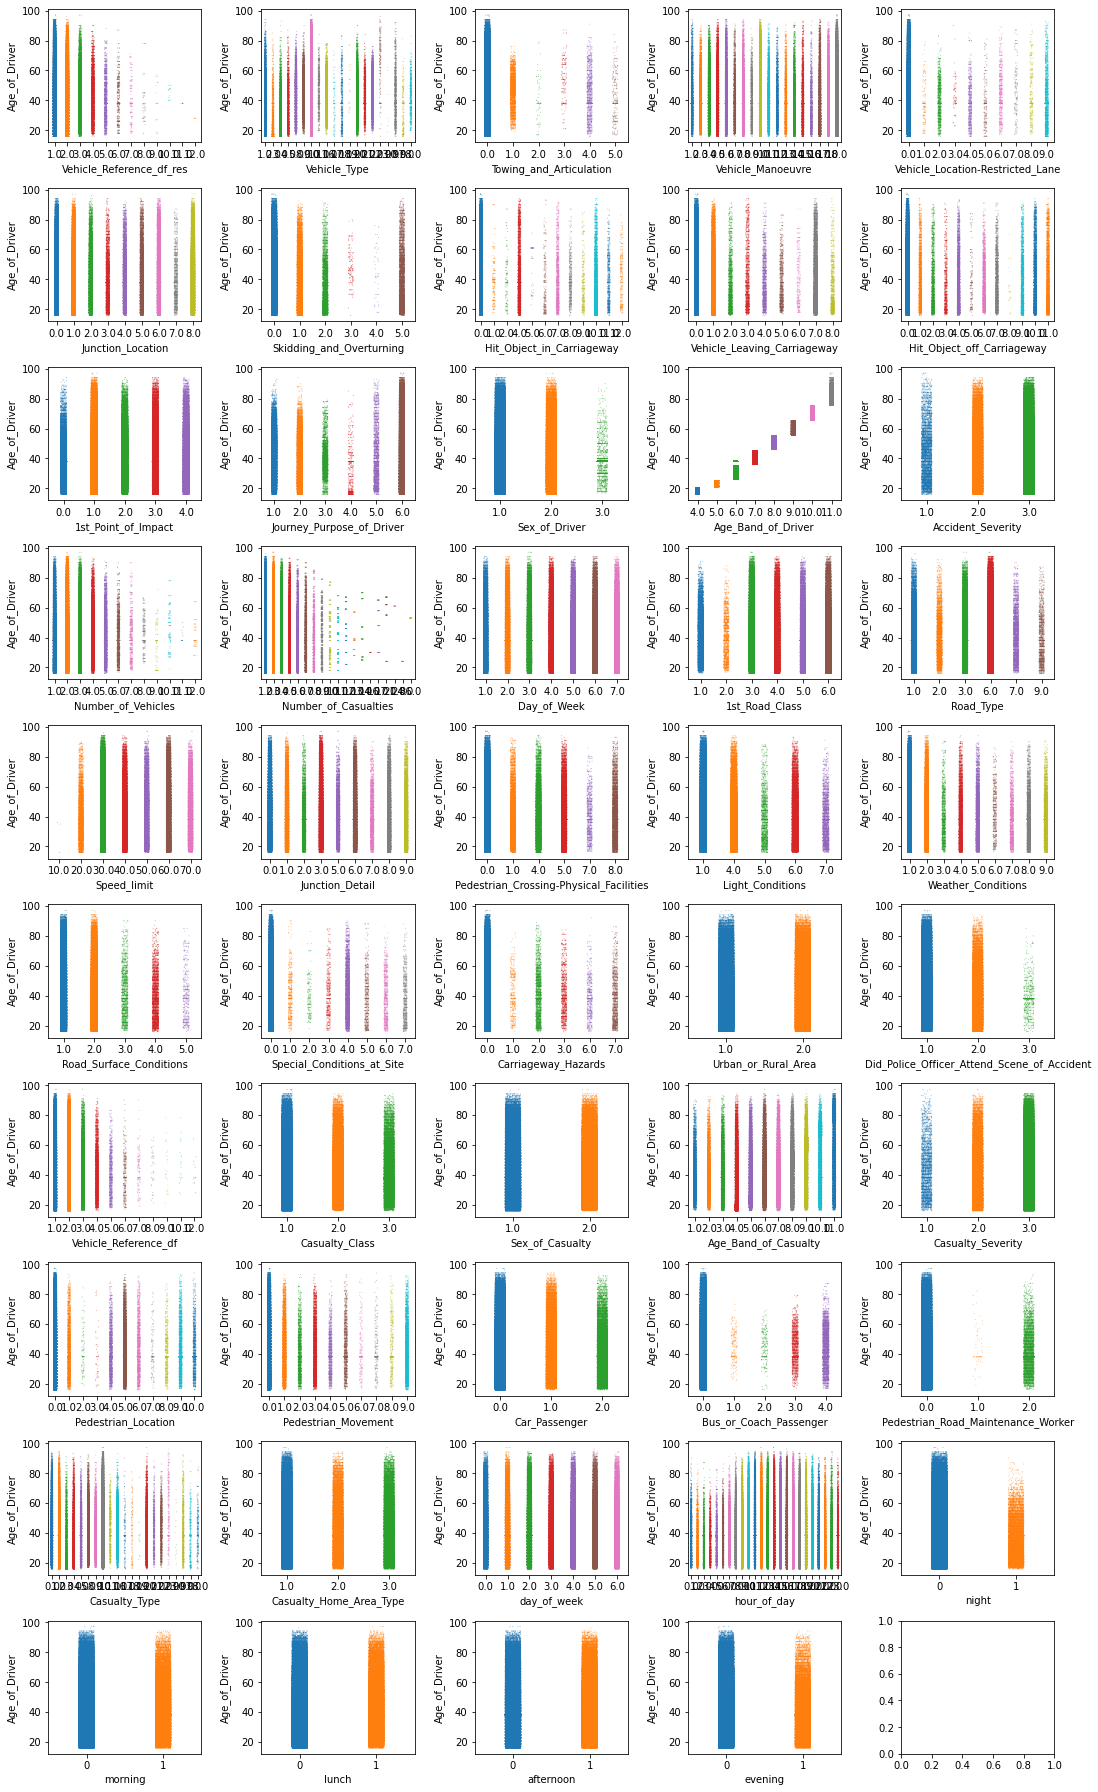

In [74]:
# Create figure object with as many rows and columns as needed
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(15, n_rows * 2.5))

# Loop through features and put each subplot on a matplotlib axis object
for col, ax in zip(df_discrete.columns, axes.ravel()):
    sns.stripplot(data=df_X, x=col, y=y_value, ax=ax, palette="tab10", size=1, alpha=0.5)
plt.tight_layout()

##### Observations 8
There are too many things to investigate here, so let’s just focus on a few. In particular, let’s focus on 6 features where some of the values appear less frequent than the rest. And to shake things up a bit, let’s use Longitude on the y-axis.

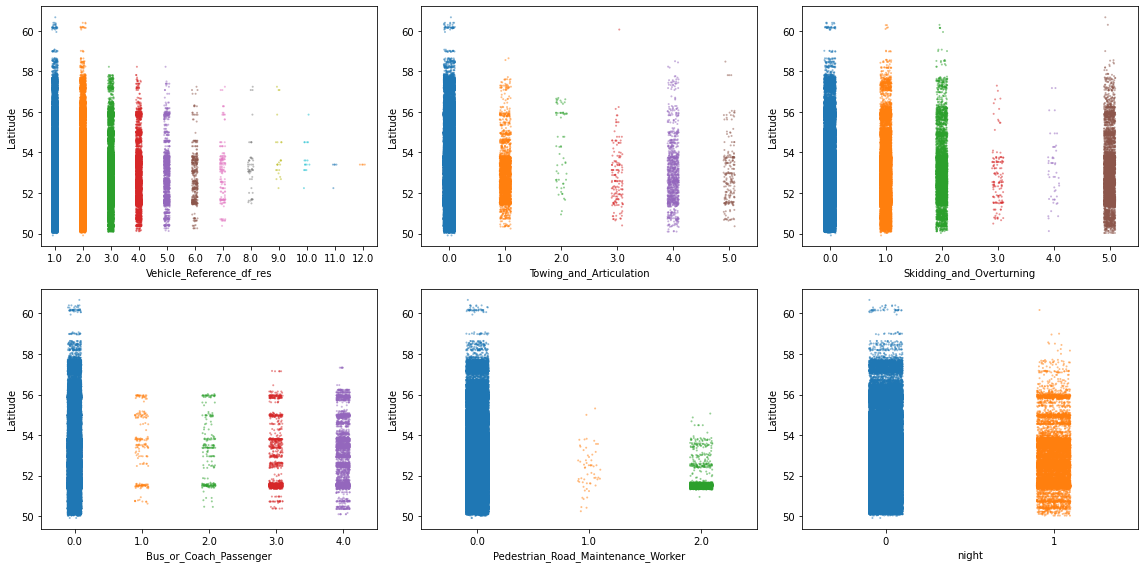

In [77]:
# Specify features of interest
selected_features = ["Vehicle_Reference_df_res", "Towing_and_Articulation",
                     "Skidding_and_Overturning", "Bus_or_Coach_Passenger",
                     "Pedestrian_Road_Maintenance_Worker", "night"]
# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))

# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.stripplot(data=df_X, x=col, y=df_X["Latitude"], ax=ax, palette="tab10", size=2, alpha=0.5)
plt.tight_layout()

##### Decision 8
If the purpose of the dataset is to prepare it for a later data science project, then it might be useful to remove discrete entries that only appear a few times. Given that an intended machine learning model might not be able to learn the the nuanced characteristics associated with these entries. If that would be our intention, we could probably remove entries with Vehicle_Reference_df_res values above ~7 or Skidding_and_Overturning values of 3 or 4 or Pedestrian_Road_Maintenance_Worker values of 1.

Also, some features seem to have more feature just below the 52nd Latitude, let’s check this a bit closer with a violineplot. And to go a step further, let’s also separate each visualization by Urban_or_Rural_Area.

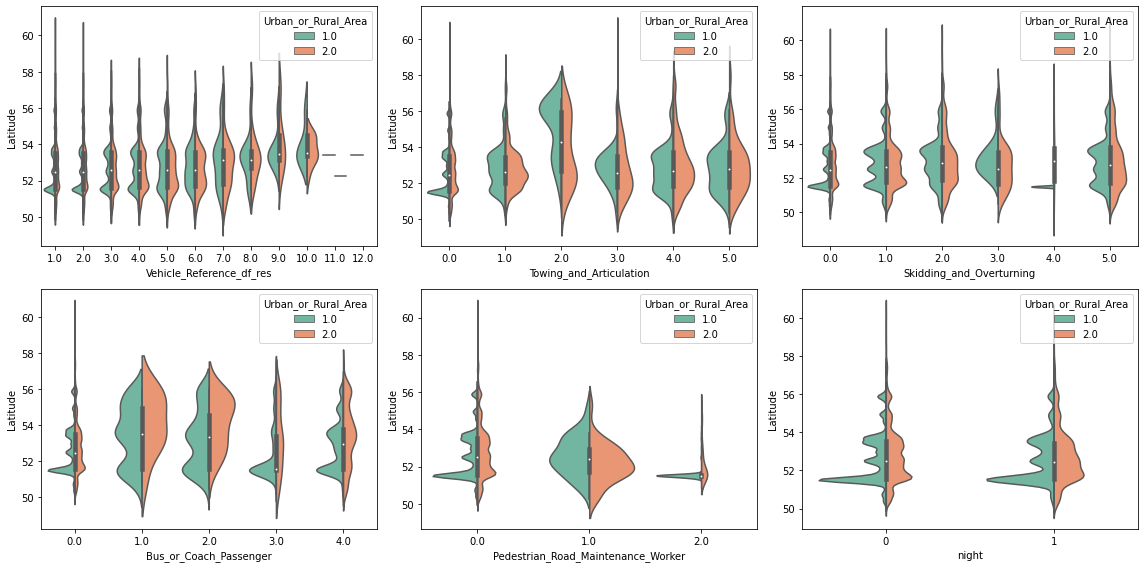

In [78]:
# Create a figure with 3 x 2 subplots
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))

# Loop through these features and plot entries from each feature against `Latitude`
for col, ax in zip(selected_features, axes.ravel()):
    sns.violinplot(
        data=df_X,
        x=col,
        y=df_X["Latitude"],
        ax=ax,
        palette="Set2",
        split=True,
        hue="Urban_or_Rural_Area",
    )
plt.tight_layout()

Interesting! We can see that some values on features are more frequent in urban, than in rural areas (and vice versa). Furthermore, as suspected, there seems to be a peak of value entries at latitude 51.5. Which is very likely due to the data recording from London, which is situated 51.5074° north.

Once more, the number of potential investigations within and between features is staggering. Exploring all of them might often not be possible. But using such short hand figures as we used so far can help you to guide interesting patterns and unique properties.

#### Feature relationships
Last, but not least, let’s take a look at relationships between features. More precisely how they correlate. The most direct approach is to use pandas’ corr() function. So let’s go ahead and compute the feature to feature correlation.

In [79]:
df_corr = df_X.corr(method="pearson")
df_corr.round(3)

Vehicle_Reference_df_res  \
Vehicle_Reference_df_res                                        1.000   
Vehicle_Type                                                    0.013   
Towing_and_Articulation                                         0.005   
Vehicle_Manoeuvre                                              -0.128   
Vehicle_Location-Restricted_Lane                               -0.013   
Junction_Location                                              -0.078   
Skidding_and_Overturning                                       -0.105   
Hit_Object_in_Carriageway                                      -0.074   
Vehicle_Leaving_Carriageway                                    -0.106   
Hit_Object_off_Carriageway                                     -0.110   
1st_Point_of_Impact                                             0.021   
Journey_Purpose_of_Driver                                       0.004   
Sex_of_Driver                                                   0.053   
Age_of_Driver                                                   0.034   
Age_Band_of_Driver                                              0.034   
Location_Easting_OSGR                                          -0.020   
Location_Northing_OSGR                                          0.008   
Longitude                                                      -0.020   
Latitude                                                        0.008   
Police_Force                                                    0.015   
Accident_Severity                                              -0.015   
Number_of_Vehicles                                              0.585   
Number_of_Casualties                                            0.184   
Day_of_Week                                                     0.007   
Local_Authority_(District)                                      0.019   
1st_Road_Class                                                 -0.125   
1st_Road_Number                                                -0.023   
Road_Type                                                      -0.060   
Speed_limit                                                     0.128   
Junction_Detail                                                -0.037   
2nd_Road_Number                                                -0.020   
Pedestrian_Crossing-Physical_Facilities                        -0.042   
Light_Conditions                                               -0.023   
Weather_Conditions                                             -0.014   
Road_Surface_Conditions                                        -0.008   
Special_Conditions_at_Site                                      0.011   
Carriageway_Hazards                                             0.006   
Urban_or_Rural_Area                                             0.072   
Did_Police_Officer_Attend_Scene_of_Accident                    -0.073   
Vehicle_Reference_df                                            0.295   
Casualty_Reference                                              0.140   
Casualty_Class                                                 -0.135   
Sex_of_Casualty                                                 0.016   
Age_of_Casualty                                                 0.025   
Age_Band_of_Casualty                                            0.032   
Casualty_Severity                                               0.027   
Pedestrian_Location                                            -0.164   
Pedestrian_Movement                                            -0.135   
Car_Passenger                                                   0.044   
Bus_or_Coach_Passenger                                         -0.034   
Pedestrian_Road_Maintenance_Worker                             -0.101   
Casualty_Type                                                   0.097   
Casualty_Home_Area_Type                                         0.010   
day_of_week                                                    -0.003   
hour_of_day                   

**Depending on the dataset and the kind of features (e.g. ordinal or continuous) you might want to use the spearman method instead of the pearson method to compute the correlation. Whereas the Pearson correlation evaluates the linear relationship between two continuous variables, the Spearman correlation evaluates the monotonic relationship based on the ranked values for each feature.**

It is rather difficult to see a clear pattern in the pandas table above. Let’s use seaborn’s clustermap() and try to visualize this output.



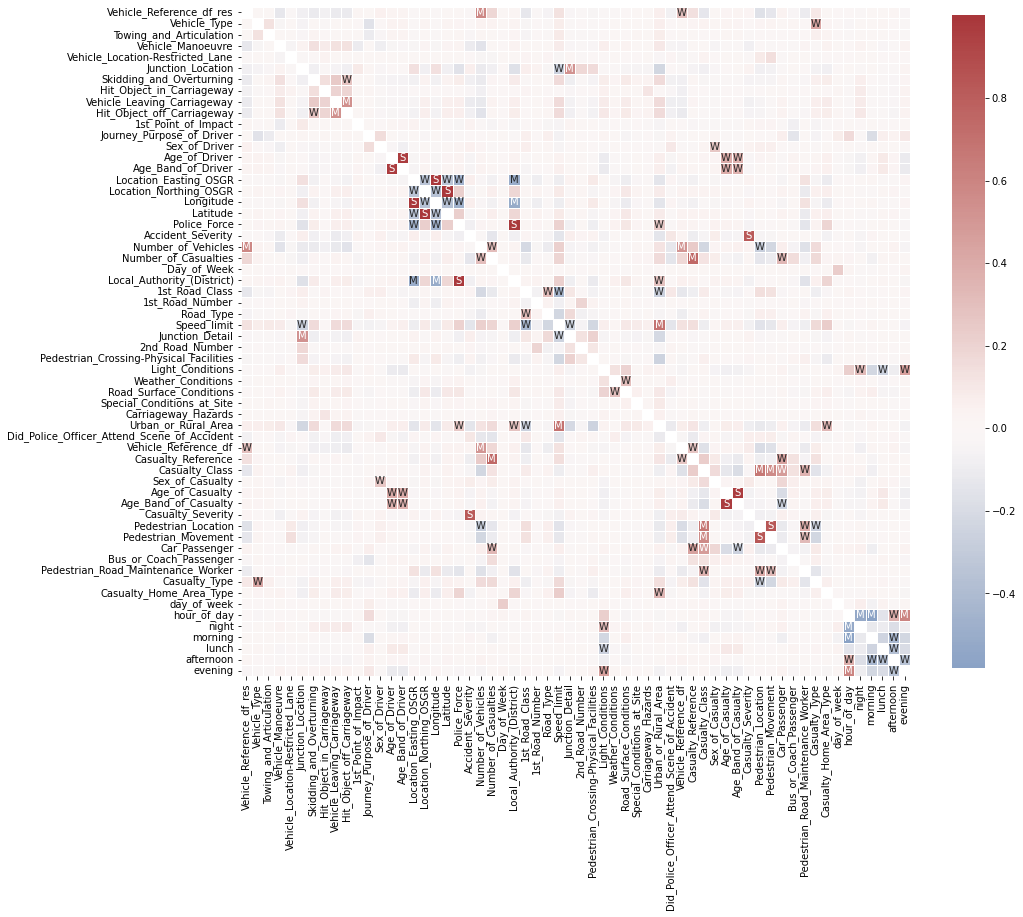

In [80]:
# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75,'S',
                  np.where(np.abs(df_corr)>0.5,'M',
                           np.where(np.abs(df_corr)>0.25,'W','')))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});


This looks already very interesting. We can see a few very strong correlations between some of the features (e.g. geographic location or daytime). If you’re interested in some particular features in particular, you could also zoom in and plot more additional information.

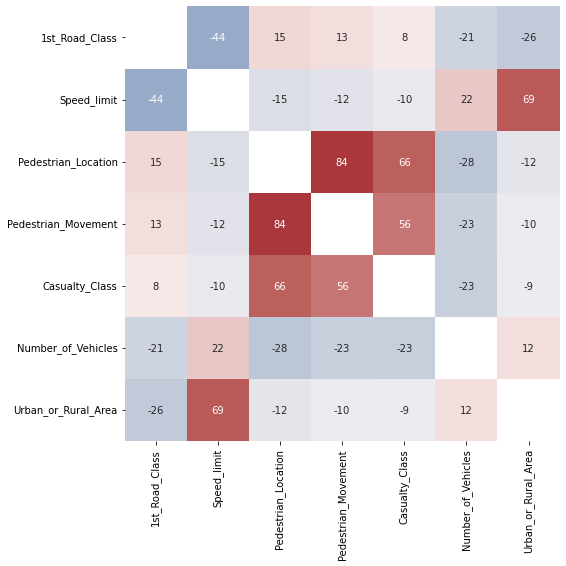

In [81]:
# Select which features to look at
features = ["1st_Road_Class", "Speed_limit", "Pedestrian_Location", "Pedestrian_Movement",
            "Casualty_Class", "Number_of_Vehicles", "Urban_or_Rural_Area"]

#  Redo correlation matrix (this time only on the selected features)
df_detail = df_X[features].corr(method="pearson")

# Plot the correlation matrix, with annotation and without colorbar
plt.figure(figsize=(8, 8))
sns.heatmap(df_detail * 100, annot=True, fmt=".0f", mask=np.eye(len(df_detail)),
            square=True, center=0, cmap="vlag", cbar=False);

Note: The multiplication with *100 is only done to remove the otherwise leading 0. in all annotated cells.

Now, finding the right kind of features to look at is not always obvious. A great alternative to improve the pattern detection is to use seaborn’s clustermap(). This method tries to hierarchically cluster the heatmap, before plotting it. In other words, it tries to reorder the features in such a way that the entries that are similar to each other are clustered closely together.

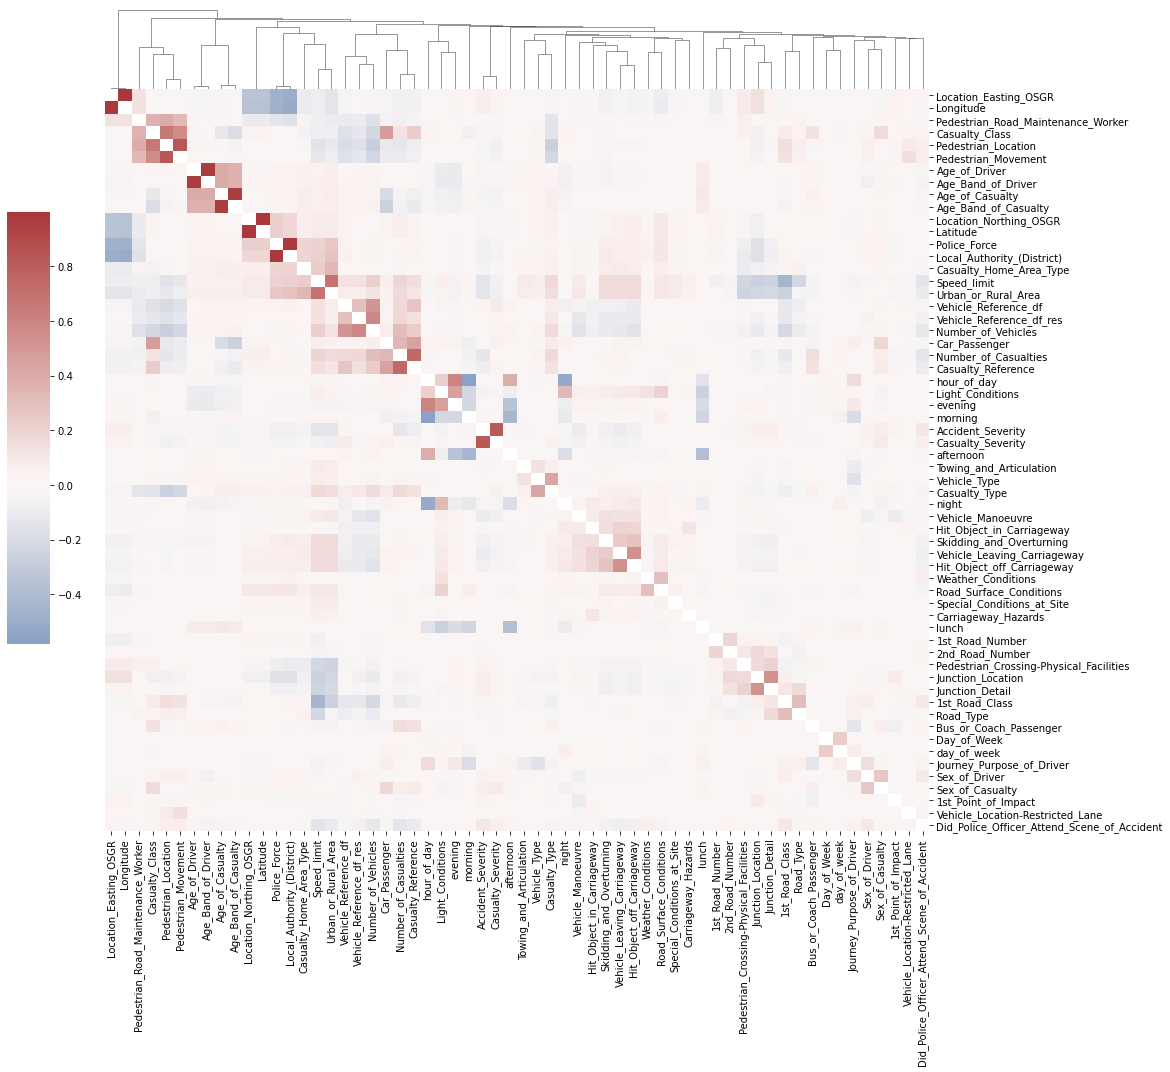

In [82]:
sns.clustermap(df_corr, mask=np.eye(len(df_corr)), center=0, cmap="vlag",
               cbar_pos=(-0.08, 0.4, 0.04, 0.4), dendrogram_ratio=(0, 0.1),
               figsize=(15, 15));

This visualization also allows the investigation of so called dendrograms (shown on the top of the previous figure). This and many more nuanced parameters

##### Observation and decision 9
We can see that multiple features seem to cluster together. For some, such as hour of the day and morning, lunch or evening, it isn’t much of a surprise. But for other’s such as Number_of_Casualties and Casualty_Reference it is. Let’s plot these two features in a scatter plot.



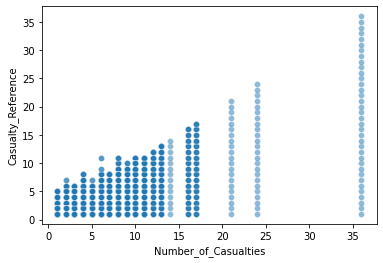

In [83]:
sns.scatterplot(data=df_X, x="Number_of_Casualties", y="Casualty_Reference", alpha=0.5);

This makes actually sense. The more casualties, the more references had to be recorded. What is curious is why some accidents seem to have more references than casualties.

If we would want to go down this rabbit hole, we could now identify which accidents have more references than casualties, with something like this:

In [84]:
# Per 'Accident_Index', select the maximum values in number of casualties and references
df_max = (
    df_X[["Accident_Index", "Number_of_Casualties", "Casualty_Reference"]]
    .groupby("Accident_Index")
    .max()
)
df_max.head()

Number_of_Casualties  Casualty_Reference
Accident_Index                                          
201501BS70001                    1.0                 1.0
201501BS70002                    1.0                 1.0
201501BS70004                    1.0                 1.0
201501BS70005                    1.0                 1.0
201501BS70008                    1.0                 1.0

Now that we have this list, we could go a step further and check where the number of references is at least 4 more than the number of casualties:

In [85]:
df_max[df_max["Number_of_Casualties"] + 4 <= df_max["Casualty_Reference"]]

Number_of_Casualties  Casualty_Reference
Accident_Index                                          
2015300017172                    2.0                 7.0
2015621500756                    2.0                 6.0
2015621500919                    6.0                11.0
2015621501509                    4.0                 8.0
2015621501715                    2.0                 6.0
2015621501780                    1.0                 5.0
2015621501854                    1.0                 5.0

… and so forth and so forth.

For now, let’s leave things at where they are and let’s look at another, non-visual approach to investigate feature relations. To do this, we can just extract all the individual correlations between the features and sort them by their coefficient.

However, we should keep in mind that the diagonal of a correlation matrix always contains the value 1 and that we only need half of the correlation matrix.

So, with some numpy trickery, we can create a mask that let’s us only consider the lower triangle, while ignoring the diagonal values.

In [86]:
lower_triangle_mask = np.tril(np.ones(df_corr.shape), k=-1).astype("bool")
lower_triangle_mask

array([[False, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True,  True, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True, False, False],
       [ True,  True,  True, ...,  True,  True, False]])

Now that we have this mask ready, we can use it to filter the correlation matrix, stack all values in a column and sort them according to their value.

In [88]:
df_corr_stacked = df_corr.where(lower_triangle_mask).stack().sort_values()
# And as a final step, let’s now take a look at the 10 most anti-correlated features.
df_corr_stacked.head(10)

morning                     hour_of_day             -0.580871
night                       hour_of_day             -0.523233
Local_Authority_(District)  Longitude               -0.511528
                            Location_Easting_OSGR   -0.505144
Police_Force                Longitude               -0.473569
                            Location_Easting_OSGR   -0.463393
Speed_limit                 1st_Road_Class          -0.436120
afternoon                   morning                 -0.428474
                            lunch                   -0.372048
Latitude                    Longitude               -0.363044
dtype: float64

In [89]:
# And the 10 most correlated features:

df_corr_stacked.tail(10)

Pedestrian_Location         Casualty_Class            0.661509
Urban_or_Rural_Area         Speed_limit               0.685887
Casualty_Reference          Number_of_Casualties      0.742381
Casualty_Severity           Accident_Severity         0.826200
Pedestrian_Movement         Pedestrian_Location       0.838741
Age_Band_of_Driver          Age_of_Driver             0.973257
Age_Band_of_Casualty        Age_of_Casualty           0.974436
Local_Authority_(District)  Police_Force              0.984810
Longitude                   Location_Easting_OSGR     0.999363
Latitude                    Location_Northing_OSGR    0.999974
dtype: float64

Correlation: As you can see, the investigation of feature correlations can be very informative. But it can also quickly become very confusing. So focusing on some features of interested with something like df_X.corrwith(df_X["Speed_limit"]) might be the better approach.

Furthermore, correlations can be deceptive if your dataframe still contains a lot of missing values, or if a feature still contains some extreme outliers. Therefore, it is always important to first make sure that your feature matrix is properly prepared before computing the correlations.